In [1]:
from scipy.optimize import curve_fit,minimize
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# from numba import njit
import argparse
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
# from my_utils.call_data import CAMB
from my_utils.mcmc.mcmc import RunMCMC
from my_utils.utils import *
from cosmoprimo import *
import pathlib

# import camb
import scipy.interpolate as interpolate
from scipy import integrate
import math

from tqdm import tqdm
import emcee                    # for MCMC part

import pickle

/global/u1/s/shreeb/BAO_bispectrum/my_utils/utils.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


# ABACUS mock preparation

In [ ]:
pk = []
bk = []
N = 0
redshifts = ["BGS","ELG","LRG","QSO"]
i=3
for file in os.listdir("data/Abacus_mocks"):
    # new_file  = file.replace(".","_")+".txt"
    # print(file,new_file)
    # os.rename("data/Abacus_mocks/"+file,"data/Abacus_mocks/"+new_file)
    if redshifts[i] in file and file[:2] == "pk":
        file_pk = np.loadtxt("data/Abacus_mocks/pk"+file[2:])
        file_bk = np.loadtxt("data/Abacus_mocks/bk"+file[2:])
        pk.append(file_pk[:,1])
        k = file_pk[:,0]
        kk = file_bk[:,0:3]
        bk.append(file_bk[:,3])
        N = N+1

pk = np.array(pk).T
bk = np.array(bk).T

pkm = np.mean(pk,axis = 1)
pcov = np.cov(pk,rowvar = True)
bkm = np.mean(bk,axis = 1)
bcov = np.cov(bk,rowvar = True)

print(redshifts[i],pkm.shape,pcov.shape,pk.shape,bkm.shape,bcov.shape,bk.shape)
# plt.plot(pkm, color ="red")
# plt.plot(bkm, color ="blue")

# plt.plot(pkm[:,0],pkm[:,2], color ="red")
# plt.plot(pkm[:,0],pkm[:,3], color ="red")

# np.savez("data/Abacus/"+ redshifts[i] +"/pk_"+redshifts[i]+".npz",k = k, pkm = pkm, pk = pk , pcov = pcov)
# np.savez("data/Abacus/"+ redshifts[i] +"/bk_"+redshifts[i]+".npz",kk = kk, bkm = bkm, bk = bk , bcov = bcov)



## If any font error occurs while plotting, DO THIS :


import matplotlib
print(matplotlib.get_cachedir()) # should return something like ~/.matplotlib


Navigate to that directory and delete the fonts file, which will be something like fontlist-v330.json

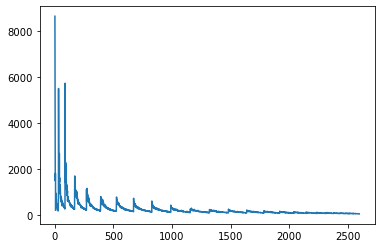

In [7]:
plt.plot(bk[:,2])

# CAMB data generation

In [3]:
camb = CAMB()

In [5]:
list_H0 = np.linspace(67.77-2.5,67.77+2.5,11)
list_Om = np.linspace(0.307-0.03,0.307+0.03,11)
list_z = [0.5]

In [6]:
list_H0, list_Om

(array([65.27, 65.77, 66.27, 66.77, 67.27, 67.77, 68.27, 68.77, 69.27,
        69.77, 70.27]),
 array([0.277, 0.283, 0.289, 0.295, 0.301, 0.307, 0.313, 0.319, 0.325,
        0.331, 0.337]))

In [2]:
# k = 0
# for h0 in list_H0:
#     for om in list_Om: 
#         ombh = 0.04825*(h0/100)**2
#         omch = (om-0.04825)*(h0/100)**2
#         results = camb.results(H0 = h0, ombh2 = ombh, omch2 = omch, omk = -0.0, all_z = list_z);
#         print(om,results.get_Omega("cdm")+results.get_Omega("baryon"),om+results.get_Omega("de"))
#         filename = f"camb_{int(np.round(h0,2)*100)}{int(om*10000)}_matterpower_z{''.join(map(str, list_z))}_{k:04}.dat"
#         parent_folder = "/home/jayashreeb/Documents/Power_Bi/nobao_project/data/camb_new/camb_python/"
#         infoname = f"infocamb_{int(np.round(h0,2)*100)}{int(om*10000)}_matterpower_z{''.join(map(str, list_z))}_{k:04}.npy"
#         info_folder = "/global/u1/s/shreeb/Project1/nobao_project/data/camb_new/camb_python_info/"
#         #np.save(info_folder + infoname, results.get_derived_params())
#         #print(filename, infoname)
#         kh,z,pkh = results.get_matter_power_spectrum(maxkh = 0.3/0.7, npoints = 200)
#         pk_kh = np.vstack((kh,pkh)).T
#         # np.savetxt(parent_folder + filename, pk_kh)
#         plt.plot(pk_kh[:,0],pk_kh[:,1])
#         #plt.legend()
#         k=k+1

# Model for bao : apply mcmc and curvefit

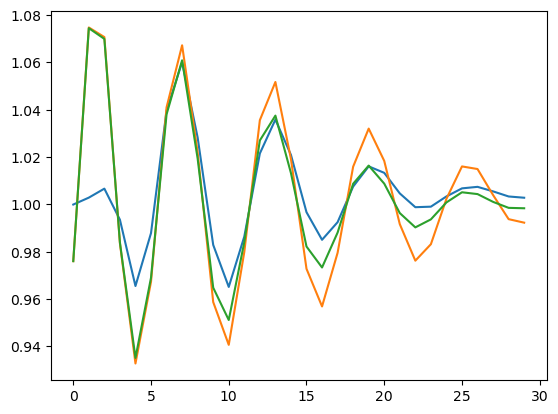

In [23]:
Bk=np.load("../Molino_mocks/bk_molino_z0.npz")
Pk=np.load("../Molino_mocks/pk_molino_z0.npz")
k,pk0,pk2,pk4=Pk['k'], Pk['pk0'], Pk['pk2'], Pk['pk4']
kk,bk0,bk2,bk4=Bk['kk'], Bk['bk0'], Bk['bk2'], Bk['bk4']
# pkm=np.mean(pk0,axis=1)
# bkm=np.mean(bk0,axis=1)

Bk=np.load("data/withbao_glam/bk_z0.50_03.npz")
Pk=np.load("data/withbao_glam/pk_z0.50_03.npz")
k,pkm,pknm,pk,pkn=Pk['k'], Pk['pkm'],Pk['pknm'],Pk['pk'],Pk['pkn']
kk,bkm,bknm,bk,bkn=Bk['kk'], Bk['bkm'], Bk['bknm'],Bk['bk'],Bk['bkn']

indb = np.where(kk[:,2]<=0.2)[0]
indp = np.where(k<=0.2)
kg = kk[indb]
bgm = bkm[indb]
bgnm = bknm[indb]
g = k[indp]
pgm = pkm[indp]
pgnm = pknm[indp]

def prepare_pk(k, E = None, use_glam = True):
    if use_glam:
        pkmf = pkm
        pknmf = pknm
        fpk = pkm
        
    else:
        pkcamb = np.loadtxt("data/camb_new/camb_python/camb_67772890_matterpower_z0.5_0057.dat")
        pkcamb[:,1] = pkcamb[:,1]/np.max(pkcamb[:,1]) * np.max(pkm)
        # print(pkcamb.shape,pkm.shape)
        fpk,pknmf,pkmf = less_baoPk(pkcamb,k,E)
#         pknmf = pknmf/np.mean(pknmf) * np.mean(pkm)
#         pkmf = pkmf/np.mean(pkmf) * np.mean(pknm) 
    
    return fpk,pkmf,pknmf

fpkg,pkmg,pknmg = prepare_pk(k,1,use_glam = True)
fpkc,pkmc,pknmc = prepare_pk(k,4.2,use_glam = False)
# plt.plot(fpkg/pknmg, label = "glam")

# plt.plot(k,pknmg)
# plt.plot(g,pknmc)
# plt.plot(pkmc/pknmc)

plt.plot(pkmg/pknmg)
plt.plot(fpkc/pknmc)
plt.plot(pkmc/pknmc)
# plt.plot(pkmc)

def model1(kk,*args):
    alpha,f,b1,b2,E,S0,S1= args

    _,pkm,pknm = prepare_pk(k,E,use_glam = False)

    pk1=np.interp(alpha*kk[:,0],k,pkm)
    pk2=np.interp(alpha*kk[:,1],k,pkm)
    pk3=np.interp(alpha*kk[:,2],k,pkm)
    res = Bi0(alpha*kk,pk1,pk2,pk3,f,b1,b2,S0,S1) #Bi_wiggle(alpha*kk,pk1,pk2,pk3,pkn1,pkn2,pkn3,f,b1,b2,S0,S1)
    return res

def model2(kk,*args):
    alpha,f,b1,b2,E,S0,S1= args

    _,pkm,pknm = prepare_pk(k,E,use_glam = False)

    pk1=np.interp(alpha*kk[:,0],k,pkm)
    pk2=np.interp(alpha*kk[:,1],k,pkm)
    pk3=np.interp(alpha*kk[:,2],k,pkm)
    res = Bi0(alpha*kk,pkn1,pkn2,pkn3,f,b1,b2,S0,S1) #Bi_wiggle(alpha*kk,pk1,pk2,pk3,pkn1,pkn2,pkn3,f,b1,b2,S0,S1)
    return res

def model3(kk,*args):
    alpha,f,b1,b2,E,S0,S1= args

    _,pkm,pknm = prepare_pk(k,E,use_glam = False)

    pk1=np.interp(alpha*kk[:,0],k,pkm)
    pk2=np.interp(alpha*kk[:,1],k,pkm)
    pk3=np.interp(alpha*kk[:,2],k,pkm)

    pkn1=np.interp(alpha*kk[:,0],k,pknm)
    pkn2=np.interp(alpha*kk[:,1],k,pknm)
    pkn3=np.interp(alpha*kk[:,2],k,pknm)

    res = Bi_wiggle(alpha*kk,pk1,pk2,pk3,pkn1,pkn2,pkn3,f,b1,b2,S0,S1)
    return res


In [24]:
k1,k2,k3=kg[:,0],kg[:,1],kg[:,2]
r=np.array(k1*k2*k3)**2
b0 = [  0.98537957,   0.09231214,   1.77502499,  -0.93034206, 4.19969726, -18.3910402 ,  23.34651357]
bopt, bcov = curve_fit(model3,kg,bgm/bgnm,b0,1/r,maxfev=10000000)

In [25]:
bopt 

array([ 0.98799731, -0.15022783,  1.78200787, -1.18175924,  4.12254572,
       -6.71277261, 22.28427863])

In [6]:
bopt_smooth = [  0.97345238,   0.08890858,   1.74861458,  -0.9195233 ,
         5.        , -19.0859239 ,  23.10156367]

In [7]:
bopt_full = [ 0.97842657,  0.03416564,  1.80925269, -0.68822191,  4.48880093, 2.89850395, 11.94816641]

(-100.0, 2500.0)

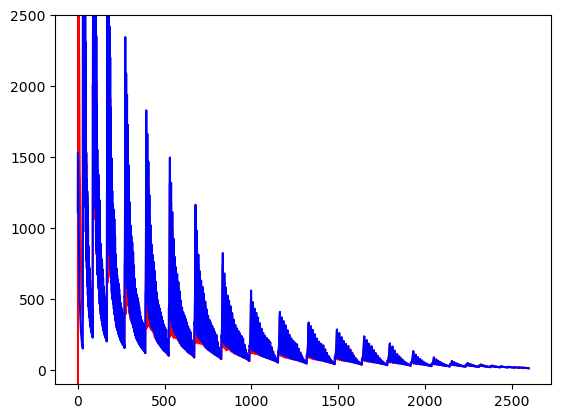

In [8]:
#bfg = 4.5*model(kg,1, 0.1, 1, -0.25,1)
plt.plot(bkm,"red")
plt.plot(model1(kk,*bopt_full),"blue")
plt.ylim(-100,2500)

(-100.0, 2500.0)

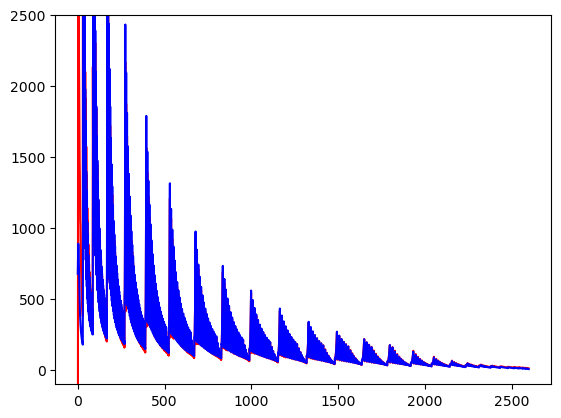

In [9]:
#bfg = 4.5*model(kg,1, 0.1, 1, -0.25,1)
plt.plot(bknm,"red")
plt.plot(model2(kk,*bopt_smooth),"blue")
plt.ylim(-100,2500)

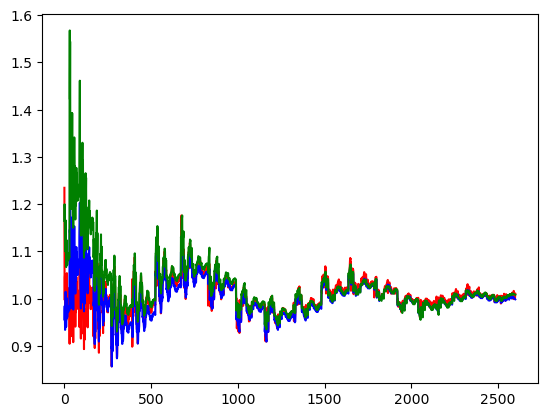

In [14]:
plt.plot(bkm/bknm,"red")
plt.plot(model1(kk,*bopt_full)/model2(kk,*bopt_full),"blue")
plt.plot(model1(kk,*bopt_full)/model2(kk,*bopt),"green")

# plt.ylim(-100,2500)

In [8]:
pkcamb = np.loadtxt("data/camb_new/camb_python/camb_67772890_matterpower_z0.5_0057.dat")
pkcamb[:,1] = pkcamb[:,1]/np.max(pkcamb[:,1]) * np.max(pkm)
# pkcamb[:,0][0] = 0
# pkcamb[:,0][0]=0
def smoothPk(k,A0,keq,a0,a2,a4,n):
    k = np.array(k)
    q = k/keq
    L = np.log(2*np.exp(1)+1.8*q)
    C = 14.2+731/(1+62.5*q)
    T = L/(L+C*(q**2))
    return A0*(a0+(T**2)*(k**n)) # +a2*(k**2))+a4*(k**4)
fpk = np.interp(k,pkcamb[:,0],pkcamb[:,1])

for i in range(1):
    Ps = lambda k,A0,keq,a0,a2,a4,n : smoothPk(k,A0,keq,a0,a2,a4,n)
    p0 = [30000,0.05,0,0,0,2]
    popt, _ = curve_fit(Ps, k ,fpk, p0, (1/k)**2, maxfev=1000000)
    print(popt)
    

[ 9.99956640e+03  9.64633100e-02 -2.86718467e-06  0.00000000e+00
  0.00000000e+00  1.23189342e+00]


(0.005, 0.3)

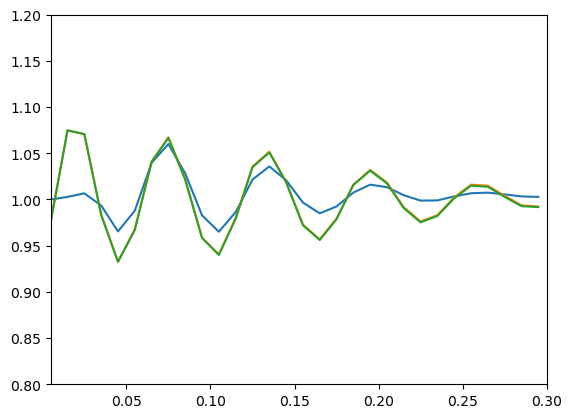

In [11]:
# plt.plot(pkcamb[:,0], pkcamb[:,1])
# plt.plot(pkcamb[:,0], pkcamb[:,1]/Ps(pkcamb[:,0],*popt))
plt.plot(k,pkm/pknm)
plt.plot(k,fpk/Ps(k,*popt))
plt.plot(k,np.interp(k,pkcamb[:,0], pkcamb[:,1])/np.interp(k,pkcamb[:,0], Ps(pkcamb[:,0],*popt)))
plt.ylim(0.8,1.2)
plt.xlim(0.005,0.3)

For kmax = 0.2, [ 1.        , -0.11796866,  1.94064156, -0.35380374]

For kmax = 0.3, [1.02921744, 1.05416385, 1.1561273 , 0.45504566]

# ABACUS smooth using curve-fit

In [2]:
import numpy as np
import argparse
import os, sys
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
from pathlib import Path
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from my_utils.mcmc.mcmc import RunMCMC
from my_utils.utils import *

import math
import warnings          # for ignoring the warnings (not recommended)
warnings.filterwarnings('ignore')

Bk_molino=np.load("../Molino_mocks/bk_molino_z0.npz")
bk_mol = Bk_molino["bk0"]

redshifts = ["BGS","ELG","LRG","QSO"]
i=2

Bk=np.load("data/Abacus/"+ redshifts[i] +"/bk_"+redshifts[i]+".npz")
Pk=np.load("data/Abacus/"+ redshifts[i] +"/pk_"+redshifts[i]+".npz")
k,pkm,pk=Pk['k'], Pk['pkm'],Pk['pk']
kk,bkm,bk=Bk['kk'], Bk['bkm'],Bk['bk']

kg,bg,bgn,cov,scaled_cov,_,_ = cutslice(0.0,0.3,kk,bkm,bk,bkm,bk,bk_mol,bk)
icov = np.linalg.inv(scaled_cov)
# index = np.where(k>=0.015 and k<=0.2)
# k,pkm = k[index],pk[index]

# def fit_smoothPk(Pkcamb,k):
#     if len(Pkcamb.shape) == 2:
#         Pcamb = Pkcamb[:,1]
#         kcamb = Pkcamb[:,0]
#     else:
#         Pcamb = Pkcamb
#         kcamb = k
#     # kcamb[0]=0
#     # Pcamb[0]=0
#     fpk = np.interp(k,kcamb,Pcamb)
#     Ps = lambda k,A0,keq,a0,a2,a4,n : smoothPk(k,A0,keq,a0,a2,a4,n)
#     p0 = [30000,0.05,0,0,0,0]
#     popt, _ = curve_fit(Ps, k ,fpk, p0, (1/k)**2, maxfev=1000000)
#     return fpk,smoothPk(k,*popt)

def model(kk,*args):
    f,b1,b2,S0,S1 = args

    fpkm,pknm = fit_smoothPk(pkm,k,method = "cosmoprimo")

    pk1=np.interp(kk[:,0],k,pkm)
    pk2=np.interp(kk[:,1],k,pkm)
    pk3=np.interp(kk[:,2],k,pkm)

    pkn1=np.interp(kk[:,0],k,pknm)
    pkn2=np.interp(kk[:,1],k,pknm)
    pkn3=np.interp(kk[:,2],k,pknm)

    pkn11=np.interp(kk[:,0],k,pknm)
    pkn12=np.interp(kk[:,1],k,pknm)
    pkn13=np.interp(kk[:,2],k,pknm)

    res = Bi_wiggle(kk,pk1,pk2,pk3,pkn1,pkn2,pkn3,f,b1,b2,S0,S1)*Bi0(kk,pkn11,pkn12,pkn13,f,b1,b2,S0,S1)
    res2 = Bi0(kk,pk1,pk2,pk3,f,b1,b2,S0,S1)
    # print(res,res2)
    return res

def get_smooth(kk,pk,*args):
    f,b1,b2,S0,S1 = args
    # S0,S1 = 0,0
    
    pk = pk/np.mean(pk)*np.mean(pkm)
    fpk,pkn = fit_smoothPk(pk,k)

    pk1=np.interp(kk[:,0],k,pk)
    pk2=np.interp(kk[:,1],k,pk)
    pk3=np.interp(kk[:,2],k,pk)

    pkn1=np.interp(kk[:,0],k,pkn)
    pkn2=np.interp(kk[:,1],k,pkn)
    pkn3=np.interp(kk[:,2],k,pkn)

    pkn11=np.interp(kk[:,0],k,pkn)
    pkn12=np.interp(kk[:,1],k,pkn)
    pkn13=np.interp(kk[:,2],k,pkn)
    
    bfull = np.array(Bi0(kk,pk1,pk2,pk3,f,b1,b2,S0,S1))
    bsmooth = np.array(Bi0(kk, pkn1,pkn2,pkn3,f,b1,b2,S0,S1))
    bwiggle = Bi_wiggle(kk,pk1,pk2,pk3,pkn1,pkn2,pkn3,f,b1,b2,S0,S1)
    
    return pk,fpk,pkn,bfull,bsmooth,bwiggle

def save_smooth_all(kk,pk,*args,filepath = "data/Abacus_mocks/", outpath = "data/Abacus/Abacus_smooth/"):
    all_pk = []
    all_bk = []
    N=0
    for file in os.listdir(filepath):
        if redshifts[i] in file and file[:2] == "pk" :
            file_pk = "pk"+file[2:]
            file_bk = "bk"+file[2:]
            pk = np.loadtxt(filepath+file_pk)[:,1]
            bk = np.loadtxt(filepath+file_bk)[:,3]
            
            pkfull,fpk,pksmooth,bfull,bsmooth,bwiggle = get_smooth(kk,pk,*args)
            all_pk = np.stack((k,pk,pksmooth)).T
            all_bk = np.stack((kk[:,0],kk[:,1],kk[:,2],bk,bfull,bsmooth)).T
            print(file_pk,file_bk,all_pk.shape,all_bk.shape)
            np.savetxt(outpath+"all_"+file_pk,all_pk)
            np.savetxt(outpath+"all_"+file_bk,all_bk)
            N=N+1
            # break
    print(N)
    # return all_pk, all_bk

kmax=0.3, kmin=0.0, nbins=2600, nmocks=25, hf = -0.009313154831199068


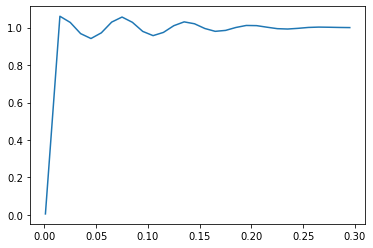

In [3]:
fpkm,pknm = fit_smoothPk(pkm,k)
plt.plot(k,fpkm/pknm)
# plt.ylim(0.7,1.1)

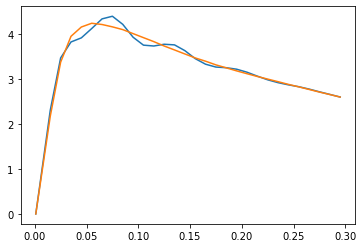

In [4]:
plt.plot(k,k*fpkm)
plt.plot(k,k*pknm)

In [32]:
k1,k2,k3=kg[:,0],kg[:,1],kg[:,2]
r=np.array(k1*k2*k3)**2
b0 = [1,1,1,1,1]
# bopt, bcov = curve_fit(model,kg,bgn,b0,1/r,maxfev=100000)
# print(bopt)

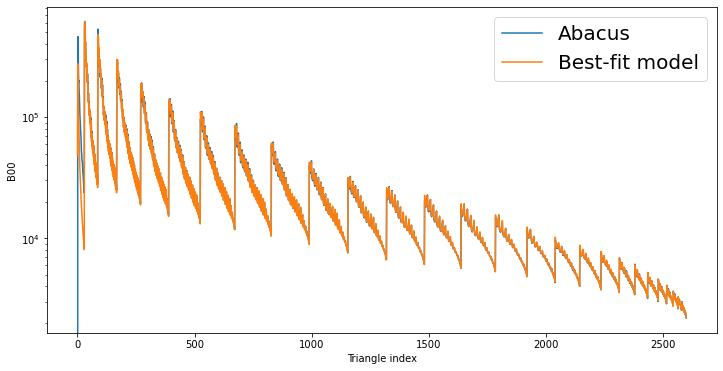

In [3]:
# bopt = [-3.33487041e-02 ,5.86745432e-01 ,-7.45187795e-02 , 6.25950689e+04, 1.02927432e-01] #ELGs
bopt_JB = [ 6.39831982e-03 , 1.05501348e+00 , 1.49932843e+00 , 8.72775638e+02, -1.53462242e+01] #LRGs
bopt_LS = [-1.44919566, 1.10827374, 4.39491818, -980.75573298, 65.87697057]

plt.figure(figsize = (12,6))
plt.plot(bg, label = "Abacus")
plt.plot(model(kg,*bopt_JB), label = "Best-fit model")
# plt.plot(model(kg,*bopt_LS), label = "Best-fit model")
plt.xlabel("Triangle index")
plt.ylabel("B00")
plt.yscale("log")
# plt.xlim(2400,2610)
# plt.ylim(10**3,10**4)
plt.legend(fontsize = 20)

In [4]:
pkf,fpk,pkn,bfull,bsmooth,bwiggle = get_smooth(kk,pkm,*bopt_JB)
pkf,fpk,pkn,bfull,bsmooth_LS,bwiggle_LS = get_smooth(kk,pkm,*bopt_LS)

(0.8, 1.2)

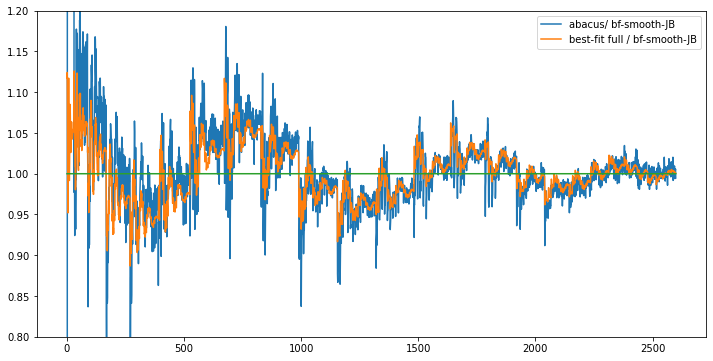

In [6]:
plt.figure(figsize = (12,6))
plt.plot(bkm/bsmooth,label = "abacus/ bf-smooth-JB")
plt.plot(bwiggle,label = "best-fit full / bf-smooth-JB")
# plt.plot(bkm/bsmooth_LS,label = "abacus/ bf-smooth-Ls")
# plt.plot(bwiggle_LS,label = "best-fit full / bf-smooth-LS")
plt.plot([1]*len(bfull))
plt.legend()
# plt.plot(bwiggle)
plt.ylim(0.8,1.2)

(0.0, 2.0)

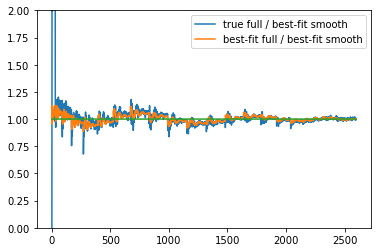

In [9]:
plt.plot(bkm/bsmooth,label = "true full / best-fit smooth")
plt.plot(bfull/bsmooth,label = "best-fit full / best-fit smooth")
plt.plot([1]*len(bfull))
plt.legend()
# plt.plot(bwiggle)
plt.ylim(0,2)

In [27]:
get_smooth_all(kk,pk,*bopt)

pk_QSOz2_5018.txt bk_QSOz2_5018.txt (30, 3) (2600, 6)
pk_QSOz2_5010.txt bk_QSOz2_5010.txt (30, 3) (2600, 6)
pk_QSOz2_5011.txt bk_QSOz2_5011.txt (30, 3) (2600, 6)
pk_QSOz2_5004.txt bk_QSOz2_5004.txt (30, 3) (2600, 6)
pk_QSOz2_5012.txt bk_QSOz2_5012.txt (30, 3) (2600, 6)
pk_QSOz2_5001.txt bk_QSOz2_5001.txt (30, 3) (2600, 6)
pk_QSOz2_5019.txt bk_QSOz2_5019.txt (30, 3) (2600, 6)
pk_QSOz2_5008.txt bk_QSOz2_5008.txt (30, 3) (2600, 6)
pk_QSOz2_5017.txt bk_QSOz2_5017.txt (30, 3) (2600, 6)
pk_QSOz2_5022.txt bk_QSOz2_5022.txt (30, 3) (2600, 6)
pk_QSOz2_5013.txt bk_QSOz2_5013.txt (30, 3) (2600, 6)
pk_QSOz2_5014.txt bk_QSOz2_5014.txt (30, 3) (2600, 6)
pk_QSOz2_5024.txt bk_QSOz2_5024.txt (30, 3) (2600, 6)
pk_QSOz2_5023.txt bk_QSOz2_5023.txt (30, 3) (2600, 6)
pk_QSOz2_5007.txt bk_QSOz2_5007.txt (30, 3) (2600, 6)
pk_QSOz2_5000.txt bk_QSOz2_5000.txt (30, 3) (2600, 6)
pk_QSOz2_5020.txt bk_QSOz2_5020.txt (30, 3) (2600, 6)
pk_QSOz2_5015.txt bk_QSOz2_5015.txt (30, 3) (2600, 6)
pk_QSOz2_5005.txt bk_QSOz2_5

# Get best fit values from a mcmc chain

In [2]:
import emcee
import corner
import matplotlib.pyplot as plt
import matplotlib.cm as cm
colors = cm.gist_heat(np.linspace(0,1,12))
from getdist import plots, MCSamples
import getdist
from scipy.interpolate import griddata
import IPython
import numpy as np
import os
from pathlib import Path
from astropy.cosmology import FlatLambdaCDM

%matplotlib inline

In [3]:
info_path = "/pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/data/camb_new/camb_python_info/"
mcmc_path = "/pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/all_mcmc_results/new_alpha/glam_parallel_kmax02/"
pk_path = "/pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/data/camb_new/camb_python/"
# mcmc_path = "/pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/beocat_mcmc_results/mcmc_results_new/"

z = 0.5
cglam = FlatLambdaCDM(H0=67.77, Om0=0.307)
dglam = cglam.comoving_distance(z).to_value()
rsglam = 147.6365451933761

list_H0 = np.linspace(67.77-2.5,67.77+2.5,11)
list_Om = np.linspace(0.307-0.03,0.307+0.03,11)
X, Y = np.meshgrid(list_Om, list_H0)

def get_errors(list_H0,list_Om):
    Z = np.zeros((len(list_H0),len(list_Om)))
    R = np.zeros((len(list_H0),len(list_Om)))
    all_H0, all_Om0, all_errors, all_rs, all_atrue, all_amodel, all_pk, all_dv, all_k , all_pkn , all_E = [], [], [],[], [], [], [], [], [], [], []
    for i in range(len(list_H0)):
        for j in range(len(list_Om)):
            h0 = list_H0[i]
            om=list_Om[j]
            # ombh = 0.04825*(h0/100)**2
            # omch = (om-0.04825)*(h0/100)**2
            match = f"{int(h0*100)}{int(om*10000)}" 
            for file in os.listdir(mcmc_path):
                name = Path(file).stem
                index = name[10:18]
                if index != "ints":
                    if index == match:
                        info_name = "info"+name[5:]+".npy"
                        pk_name = name[5:]+".dat"
                        # print(file,info_name,h0,om)
                        # print(info_path,info_name)
                        info = np.load(info_path + info_name, allow_pickle = True)
                        pkcamb = np.loadtxt(pk_path + pk_name)
                        rscamb = info.item()['rdrag']
                        # H0 = int(name[10:12])+int(name[12:14])/100
                        # omch2 = int(name[14:18])/10000
                        # ombh2 = 0.04825*(H0/100)**2
                        # Om0 = (ombh2+omch2)/((H0/100)**2)
                        # print(H0,omch2,Om0)
                        ccamb = FlatLambdaCDM(H0=h0, Om0=om)
                        dcamb = ccamb.comoving_distance(z).to_value()
                        
                        alpha_true = ((rsglam/rscamb)*(67.77/h0)) #(dcamb/rscamb)/(dglam/rsglam)

                        reader = emcee.backends.HDFBackend(mcmc_path + file,read_only=True)
                        flat_samples = reader.get_chain(discard=1500, thin=100, flat=True)
                        # print(flat_samples.shape)
                        alpha_model = np.mean(flat_samples[:,0])
                        E = np.mean(flat_samples[:,-1])
                        
                        _,pks,pk = less_baoPk(pkcamb,pkcamb[:,0],1,E)
                        
                        error = (np.abs(alpha_true-alpha_model)/alpha_true)*100
                        # print(alpha_true,alpha_model)

                        all_H0.append(h0)
                        all_Om0.append(om)
                        all_errors.append(error)
                        all_rs.append(rscamb)
                        all_pk.append(pk)
                        all_pkn.append(pks)
                        all_dv.append(dcamb)
                        all_k.append(pkcamb[:,0])
                        all_amodel.append(alpha_model)
                        all_atrue.append(alpha_true)
                        Z[i,j]=error
                        R[i,j]=rscamb
                        all_E.append(E)
                        #print(H0,Om0,error)
                        
    return np.array(all_H0), np.array(all_Om0), np.array(all_errors), np.array(Z),np.array(R),np.array(all_rs),np.array(all_amodel),np.array(all_atrue), np.array(all_pk), np.array(all_pkn), np.array(all_dv), np.array(all_k),np.array(all_E)

all_H0,all_Om0,all_errors,Z,R ,all_rs, all_amodel, all_atrue, all_pk ,all_pkn, all_dv, all_k , all_E= get_errors(list_H0,list_Om)

# np.savez("plots_data/sys_data.npz", H = all_H0, Om = all_Om0, errors = all_errors)

/global/homes/s/shreeb/anaconda3/envs/bispectrum/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/global/u1/s/shreeb/BAO_bispectrum/my_utils/utils.py:14: RuntimeWarning: invalid value encountered in log
  L = np.log(2*np.exp(1)+1.8*q)


In [4]:
all_amodel[60],all_amodel[57]

(1.0001263229312694, 0.9858347817708885)

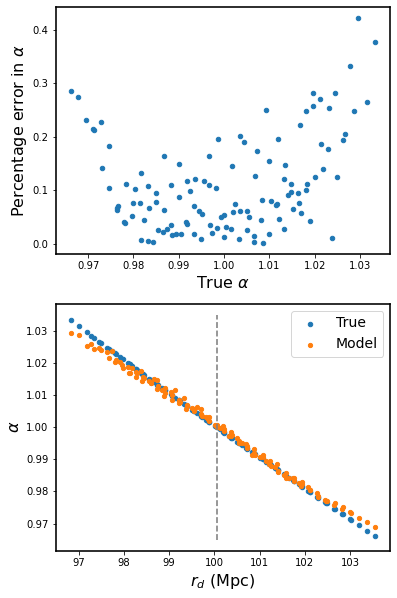

In [82]:
fig, ax = plt.subplots(2,sharex=False, sharey = False, figsize = (6,10))

for axis in ['top','bottom','left','right']:
    ax[0].spines[axis].set_linewidth(1.6)
    ax[1].spines[axis].set_linewidth(1.6)

ax[0].scatter(all_atrue, all_errors,s = 20)
ax[0].set_xlabel(r"True $\alpha$", fontsize = 16)
ax[0].set_ylabel(r"Percentage error in $\alpha$", fontsize = 16)
# ax[0].set_xlim([min(all_atrue), max(all_atrue)])
# ax[0].set_xticks([0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30])
# ax[0].set_ylim([0.92, 1.08])
# ax[0].set_yticks(np.arange(0.94, 1.08, step=0.03))
# ax[0].tick_params(direction='in', size=6, labelsize=12)
# ax[0].grid(True, alpha=0.4, linewidth=1, linestyle='--')
# plt.tight_layout()
# ax[0].legend(loc = "lower right", fontsize = 14)

ax[1].scatter(all_rs*all_H0/100, all_atrue, s = 20, label =  "True")
ax[1].scatter(all_rs*all_H0/100, all_amodel, s = 18, label = "Model")
ax[1].vlines(all_rs[60]*all_H0[60]/100,color = "grey", ymin = 0.965, ymax = 1.035, ls = "--", lw = 1.6)

ax[1].set_xlabel(r"$r_d$ (Mpc)", fontsize = 16)
ax[1].set_ylabel(r"$\alpha$", fontsize = 16)
# ax[0].set_xlim([0, 0.3])
# ax[0].set_xticks([0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30])
# ax[0].set_ylim([0.92, 1.08])
# ax[0].set_yticks(np.arange(0.94, 1.08, step=0.03))
# ax[0].tick_params(direction='in', size=6, labelsize=12)
# ax[1].grid(True, alpha=0.4, linewidth=1, linestyle='--')
# plt.tight_layout()
ax[1].legend(loc = "upper right", fontsize = 14)

plt.savefig("plots_new/new_sys.png", dpi = 200)


In [442]:
from collections import Counter
import random
random.seed(1)
logrs_perc = np.linspace(min(all_atrue), max(all_atrue), 26)
# logrs_perc = np.percentile(all_atrue, np.linspace(0, 100, 26))
logrs_bins = np.digitize(all_atrue, logrs_perc)
print(Counter(logrs_bins))
inds = [(np.where(logrs_bins==i)[0]) for i in range(1,len(logrs_perc),1)]

Counter({11: 7, 17: 7, 6: 7, 14: 7, 16: 7, 19: 7, 7: 6, 9: 6, 13: 6, 20: 6, 18: 5, 22: 5, 8: 5, 10: 5, 12: 5, 4: 5, 15: 4, 21: 4, 23: 3, 5: 3, 2: 3, 24: 2, 3: 2, 1: 2, 26: 1, 25: 1})


In [443]:
inds

[array([ 99, 110]),
 array([ 77,  88, 111]),
 array([ 66, 100]),
 array([ 44,  55,  78,  89, 112]),
 array([ 33,  67, 101]),
 array([ 11,  22,  45,  56,  79,  90, 113]),
 array([  0,  34,  57,  68,  91, 102]),
 array([ 12,  23,  46,  80, 114]),
 array([  1,  35,  58,  69,  92, 103]),
 array([ 13,  24,  47,  81, 115]),
 array([  2,  25,  36,  59,  70,  93, 104]),
 array([ 14,  48,  71,  82, 116]),
 array([  3,  26,  37,  60,  94, 105]),
 array([ 15,  38,  49,  72,  83, 106, 117]),
 array([ 4, 27, 61, 95]),
 array([ 16,  39,  50,  73,  84, 107, 118]),
 array([  5,  28,  51,  62,  85,  96, 119]),
 array([  6,  17,  40,  74, 108]),
 array([ 18,  29,  52,  63,  86,  97, 120]),
 array([  7,  41,  64,  75,  98, 109]),
 array([19, 30, 53, 87]),
 array([ 8, 31, 42, 65, 76]),
 array([20, 43, 54]),
 array([ 9, 32]),
 array([21])]

In [444]:
min_ind = [i[all_errors[i] == min(all_errors[i])][0] for i in inds]
print(min_ind)

[99, 111, 100, 44, 101, 113, 0, 80, 35, 24, 59, 14, 60, 72, 61, 39, 62, 74, 18, 7, 30, 8, 54, 9, 21]


Text(0, 0.5, ' Percentage error in $\\alpha$')

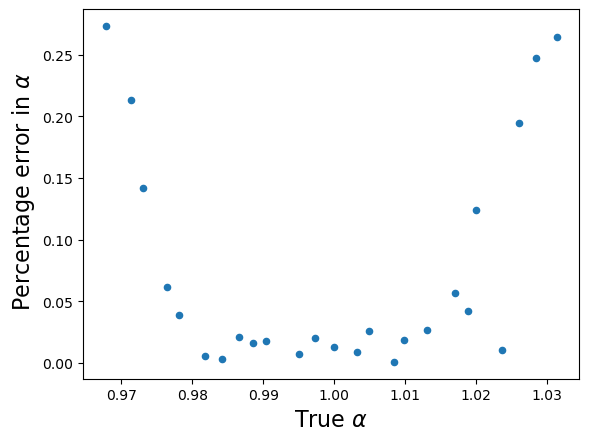

In [445]:
plt.scatter(all_atrue[min_ind], all_errors[min_ind],s = 20)
plt.xlabel(r"True $\alpha$", fontsize = 16)
plt.ylabel(r" Percentage error in $\alpha$", fontsize = 16)
# plt.savefig("plots_new/perror_rdragh.png", dpi =200)

In [305]:
ind = np.where((all_rs<147.5) & (all_rs>147.3))
all_rs[ind], all_H0[ind], ind

(array([147.48991086, 147.31949209, 147.47303831, 147.4186769 ,
        147.38323791, 147.3670979 ]),
 array([65.77, 66.27, 68.77, 69.27, 69.77, 70.27]),
 (array([ 21,  31,  80,  90, 100, 110]),))

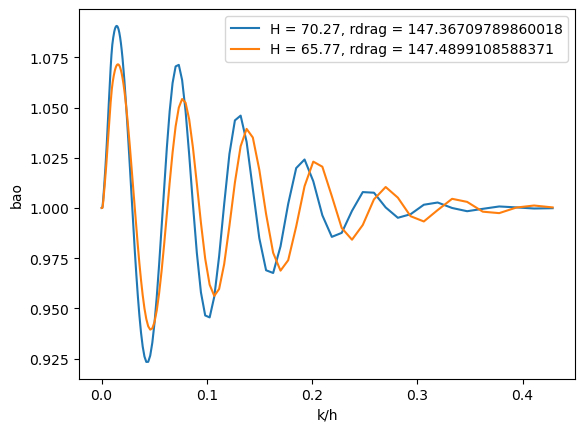

In [281]:
plt.plot(all_k[110],all_pk[110]/all_pkn[110], label = f"H = {all_H0[110]}, rdrag = {all_rs[110]}")
plt.plot(all_k[21],all_pk[21]/all_pkn[21], label = f"H = {all_H0[21]}, rdrag = {all_rs[21]}")
plt.xlabel("k/h")
plt.ylabel("bao")
plt.legend()

In [282]:
ind = np.where(all_H0 == 67.77)
all_rs[ind], all_H0[ind], ind

(array([151.4772937 , 150.68112081, 149.89942027, 149.13172029,
        148.37756419, 147.63654519, 146.9082771 , 146.19233559,
        145.48836953, 144.79604074, 144.11501865]),
 array([67.77, 67.77, 67.77, 67.77, 67.77, 67.77, 67.77, 67.77, 67.77,
        67.77, 67.77]),
 (array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),))

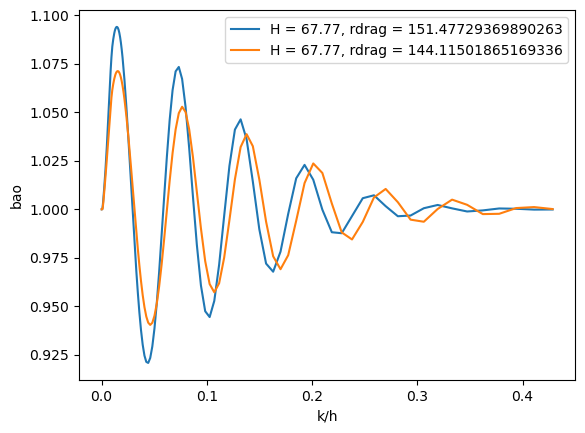

In [283]:
plt.plot(all_k[55],all_pk[55]/all_pkn[55], label = f"H = {all_H0[55]}, rdrag = {all_rs[55]}")
plt.plot(all_k[65],all_pk[65]/all_pkn[65], label = f"H = {all_H0[65]}, rdrag = {all_rs[65]}")
plt.xlabel("k/h")
plt.ylabel("bao")
plt.legend()

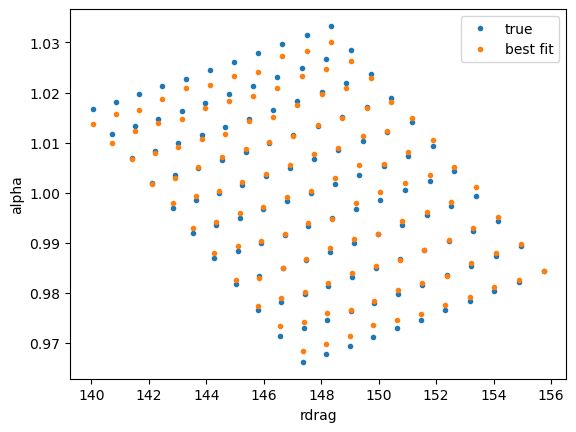

In [284]:
plt.plot(all_rs,all_atrue,".", label = "true")
plt.plot(all_rs,all_amodel,".", label = "best fit")
plt.ylabel("alpha")
plt.xlabel("rdrag")
plt.legend()


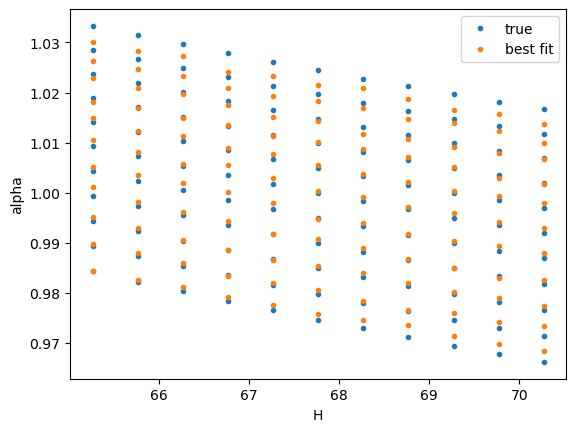

In [285]:
plt.plot(all_H0,all_atrue,".", label = "true")
plt.plot(all_H0,all_amodel,".", label = "best fit")
plt.ylabel("alpha")
plt.xlabel("H")
plt.legend()

Text(0, 0.5, '$rdrag$')

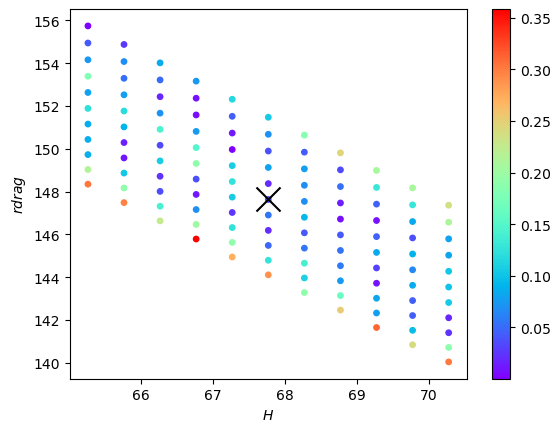

In [286]:
plt.scatter(all_H0, all_rs, s = 15, c = all_errors,cmap = "rainbow")
plt.colorbar()
plt.scatter(all_H0[60],all_rs[60], s = 300 , c = "black", marker = "x")
plt.xlabel(r"$H$")
plt.ylabel(r"$rdrag$")
# plt.savefig("plots/systematic.png", dpi = 150)

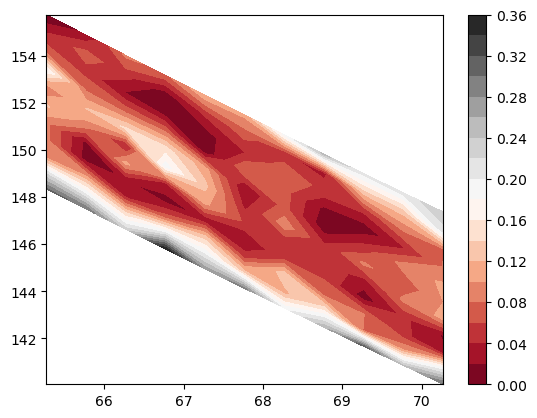

In [287]:
plt.contourf(Y, R, Z, 20, cmap='RdGy')
plt.colorbar();

In [288]:
all_atrue[60], all_amodel[60]

(1.0, 1.0003388853695983)

In [289]:
all_H0[60], all_Om0[60],all_rs[60], rsglam, all_errors[60]

(67.77, 0.307, 147.6365451933761, 147.6365451933761, 0.03388853695982519)

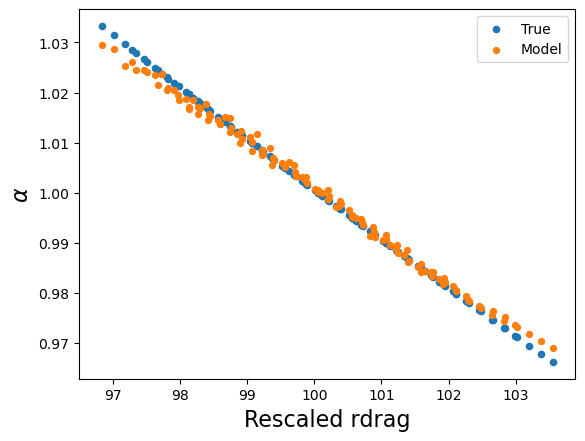

In [448]:
plt.scatter(all_rs*all_H0/100, all_atrue, s = 20, label =  "True")
plt.scatter(all_rs*all_H0/100, all_amodel, s = 18, label = "Model")

plt.xlabel(r"Rescaled rdrag", fontsize = 16)
plt.ylabel(r"$\alpha$", fontsize = 16)
plt.legend()
plt.savefig("plots_new/alpha_rdragh.png", dpi =200)


Text(0, 0.5, 'Percentage error in alpha')

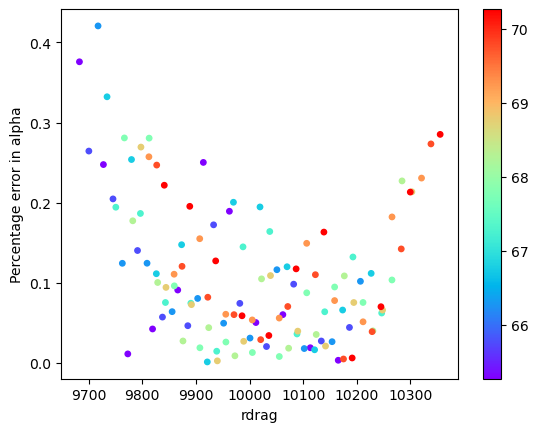

In [315]:
# plt.plot(all_rs,all_errors)
plt.scatter(all_rs*all_H0, all_errors, s = 15, c = all_H0.flatten(),cmap = "rainbow")
plt.colorbar()
plt.xlabel("rdrag")
plt.ylabel("Percentage error in alpha")

(array([148.35074456, 148.86969925, 148.17417543, 148.72059553,
        148.01427262, 148.58887836, 148.47419613, 148.37756419,
        148.29918585, 148.23936601, 148.99274034, 148.19838912,
        148.17688722]),
 array([0.37588035, 0.14008098, 0.2045593 , 0.06369338, 0.12420865,
        0.00089385, 0.14464749, 0.00765809, 0.03517407, 0.0751231 ,
        0.23058049, 0.18203925, 0.27326513]),
 array([1.03330378, 1.02187366, 1.0266703 , 1.01518051, 1.02002495,
        1.00847162, 1.00174907, 0.99500586, 0.98824059, 0.98145137,
        0.96944029, 0.97463654, 0.96779232]),
 array([1.02941979, 1.02044221, 1.02457015, 1.01453391, 1.01875799,
        1.0084626 , 1.00319808, 0.99508205, 0.98789299, 0.98218867,
        0.97167563, 0.97641076, 0.97043695]))

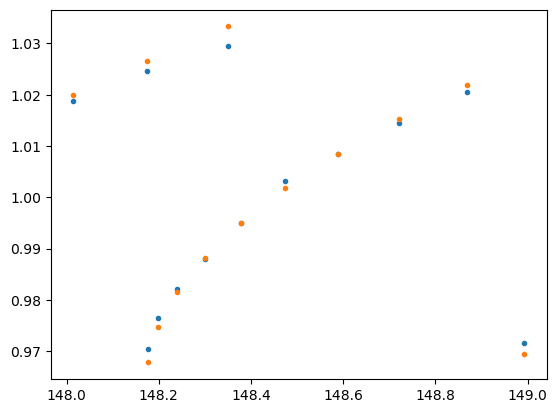

In [316]:
ind = np.where((all_rs < 149) & (all_rs>148))
plt.plot(all_rs[ind],all_amodel[ind],".")
plt.plot(all_rs[ind],all_atrue[ind],".")
all_rs[ind],all_errors[ind],all_atrue[ind], all_amodel[ind]

Text(0, 0.5, 'Percentage error in alpha')

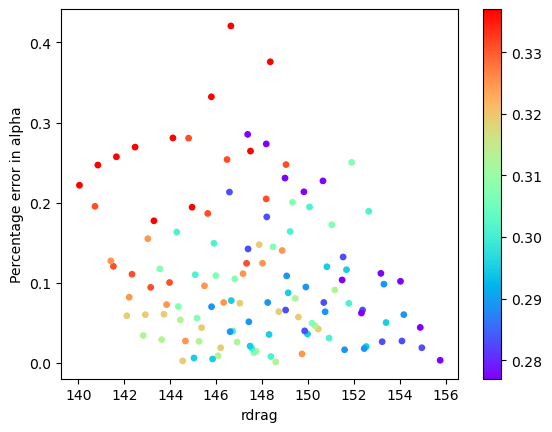

In [317]:
# plt.plot(all_rs,all_errors)
plt.scatter(all_rs, all_errors, s = 15, c = all_Om0.flatten(),cmap = "rainbow")
plt.colorbar()
plt.xlabel("rdrag")
plt.ylabel("Percentage error in alpha")

Text(0, 0.5, '$\\Omega_m$')

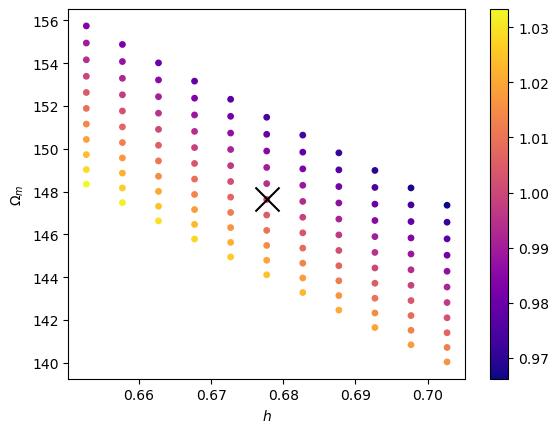

In [318]:
plt.scatter(np.array(all_H0)/100,all_rs, s = 15, c = all_atrue,cmap = "plasma")
plt.colorbar()
plt.scatter(0.6777,all_rs[60], s = 300 , c = "black", marker = "x")
plt.xlabel(r"$h$")
plt.ylabel(r"$\Omega_m$")
# plt.savefig("plots/systematic.png", dpi = 150)

Text(0, 0.5, '$\\Omega_m$')

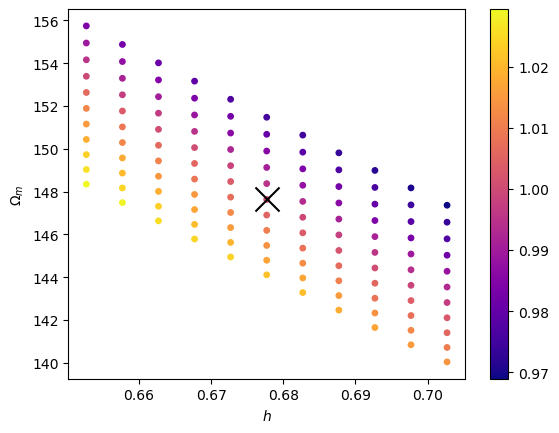

In [319]:
plt.scatter(np.array(all_H0)/100, all_rs, s = 15, c = all_amodel,cmap = "plasma")
plt.colorbar()
plt.scatter(0.6777, all_rs[60], s = 300 , c = "black", marker = "x")
plt.xlabel(r"$h$")
plt.ylabel(r"$\Omega_m$")
# plt.savefig("plots/systematic.png", dpi = 150)

Text(0, 0.5, '$\\Omega_m$')

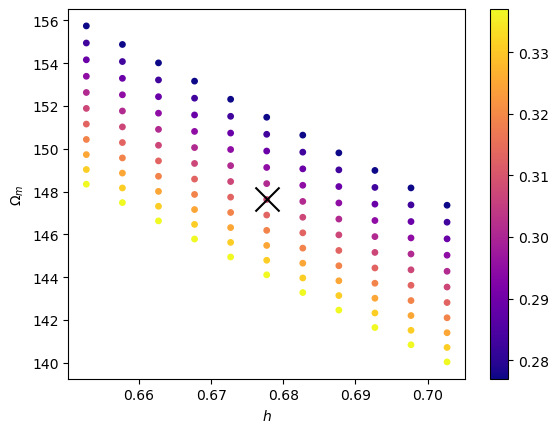

In [320]:
plt.scatter(np.array(all_H0)/100, all_rs, s = 15, c = all_Om0,cmap = "plasma")
plt.colorbar()
plt.scatter(0.6777, all_rs[60], s = 300 , c = "black", marker = "x")
plt.xlabel(r"$h$")
plt.ylabel(r"$\Omega_m$")
# plt.savefig("plots/systematic.png", dpi = 150)

In [325]:
Y.T[5],X.T[5],R.T[5],Z.T[5]

(array([65.27, 65.77, 66.27, 66.77, 67.27, 67.77, 68.27, 68.77, 69.27,
        69.77, 70.27]),
 array([0.307, 0.307, 0.307, 0.307, 0.307, 0.307, 0.307, 0.307, 0.307,
        0.307, 0.307]),
 array([151.89066376, 151.02649955, 150.16912617, 149.31886784,
        148.47419613, 147.63654519, 146.80547746, 145.98094551,
        145.16256568, 144.35063853, 143.54507385]),
 array([5.38968543, 4.360817  , 3.26762735, 2.04660367, 1.02691663,
        0.06664185, 1.2573595 , 2.32108417, 3.51914909, 4.67152878,
        5.8730674 ]))

[0.307 0.307 0.307 0.307 0.307 0.307 0.307 0.307 0.307 0.307 0.307] [65.27 65.77 66.27 66.77 67.27 67.77 68.27 68.77 69.27 69.77 70.27]


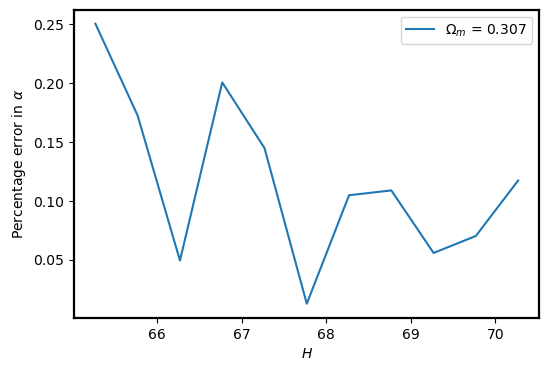

In [327]:
fig,ax = plt.subplots(figsize = (6,4))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.6)
print(X.T[5],Y.T[5])
plt.plot(Y.T[5],Z.T[5], label = r"$\Omega_m$ = 0.307")
plt.xlabel(r"$H$")
plt.ylabel(r"Percentage error in $\alpha$")
plt.legend()

[0.277 0.283 0.289 0.295 0.301 0.307 0.313 0.319 0.325 0.331 0.337] [67.77 67.77 67.77 67.77 67.77 67.77 67.77 67.77 67.77 67.77 67.77]


Text(0, 0.5, 'Percentage error in $\\alpha$')

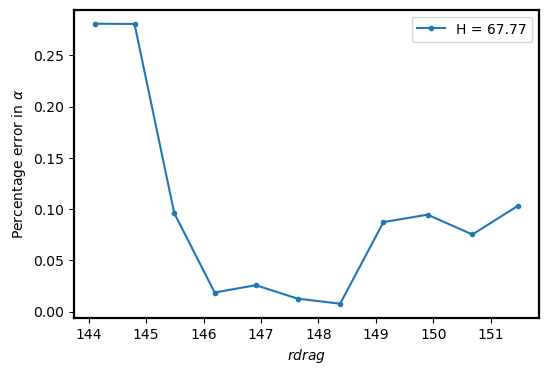

In [326]:
fig,ax = plt.subplots(figsize = (6,4))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.6)
print(X[5],Y[5])
plt.plot(R[5],Z[5],".-", label = "H = 67.77")
plt.legend()
plt.xlabel(r"$rdrag$")
plt.ylabel(r"Percentage error in $\alpha$")


[0.307 0.307 0.307 0.307 0.307 0.307 0.307 0.307 0.307 0.307 0.307] [65.27 65.77 66.27 66.77 67.27 67.77 68.27 68.77 69.27 69.77 70.27]


Text(0, 0.5, 'Percentage error in $\\alpha$')

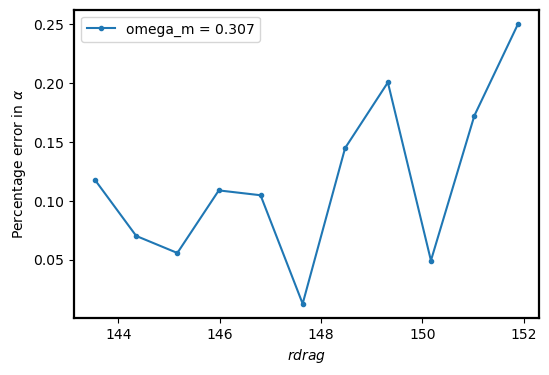

In [325]:
fig,ax = plt.subplots(figsize = (6,4))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.6)
print(X.T[5],Y.T[5])
plt.plot(R.T[5],Z.T[5],".-", label = "omega_m = 0.307")
plt.legend()
plt.xlabel(r"$rdrag$")
plt.ylabel(r"Percentage error in $\alpha$")

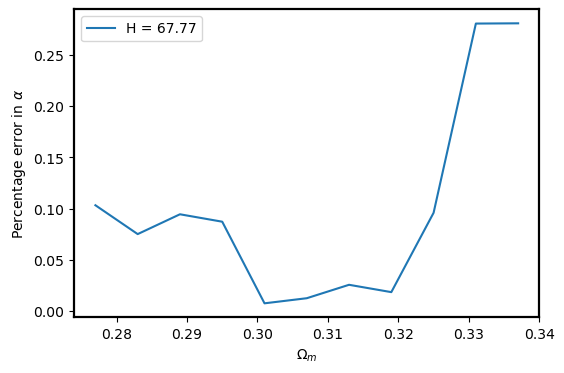

In [324]:
fig,ax = plt.subplots(figsize = (6,4))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.6)
plt.plot(X[5],Z[5], label = "H = 67.77")
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"Percentage error in $\alpha$")
plt.legend()

Text(0, 0.5, 'Percentage error in $\\alpha$')

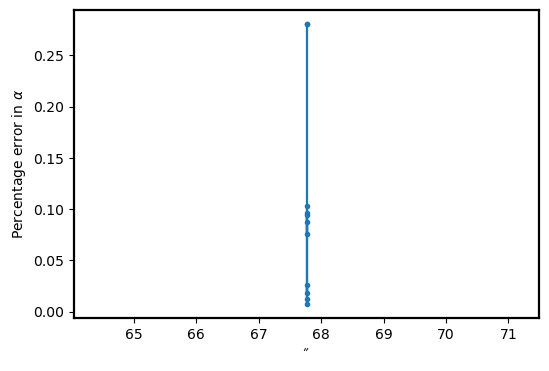

In [323]:
fig,ax = plt.subplots(figsize = (6,4))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.6)
j = 55
plt.plot(all_H0[j:j+11], all_errors[j:j+11], ".-",linewidth = 1.6,label = "H = " + str(all_H0[j]))
plt.xlabel(r"$\H$")
plt.ylabel(r"Percentage error in $\alpha$")
# plt.legend()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig("plots/1d_systematic.png", dpi = 150, bbox_inches='tight')

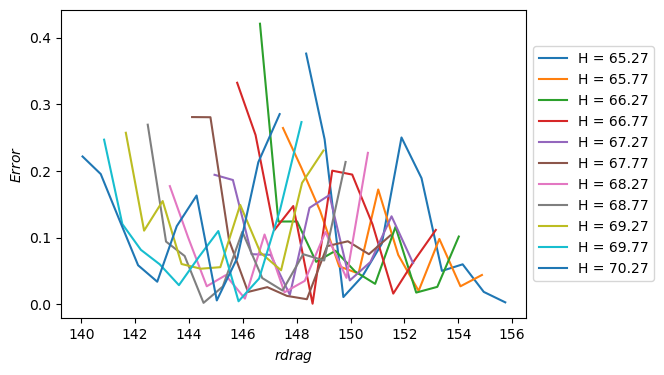

In [322]:
plt.figure(figsize = (6,4))
for j in range(0,121,11):
    plt.plot(all_rs[j:j+11], all_errors[j:j+11], label = "H = " + str(all_H0[j]))
plt.xlabel(r"$rdrag$")
plt.ylabel(r"$Error$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig("plots/1d_systematic.png", dpi = 150, bbox_inches='tight')

### Outdated code

In [6]:
# info_path = "/global/homes/s/shreeb/BAO_bispectrum/nobao_project/data/camb_new/camb_python_info/"
# mcmc_path = "/global/cscratch1/sd/shreeb/BAO_Bispectrum_with_data/nobao_project/beocat_mcmc_results/mcmc_results_new/"

# z = 0.5
# cglam = FlatLambdaCDM(H0=67.77, Om0=0.307)
# dglam = cglam.comoving_distance(z)
# rsglam = 147.82
# # ind = np.arange(0,66)

# all_H0 = []
# all_Om0 = []
# all_errors = []

# list_H0 = np.linspace(64,72,10)
# list_omch2 = np.linspace(0.112,0.142,10)

# for file in os.listdir(mcmc_path):
#     name = Path(file).stem
#     index = name[-4:]
#     if index != "ints":
#         print(index)
#         if int(index) == ind:
#             print(file)
#             info_name = "info"+name[5:]+".npy"
#             info = np.load(info_path + info_name, allow_pickle = True)
#             rscamb = info.item()['rdrag']
#             H0 = int(name[10:12])+int(name[12:14])/100
#             omch2 = int(name[14:18])/10000
#             ombh2 = 0.04825*(H0/100)**2
#             Om0 = (ombh2+omch2)/((H0/100)**2)
#             #print(H0,omch2,Om0)
#             ccamb = FlatLambdaCDM(H0=H0, Om0=Om0)
#             dcamb = ccamb.comoving_distance(z)
            
#             #print(dcamb)
#             alpha_true = (dcamb/rscamb)/(dglam/rsglam)
            
            
#             reader = emcee.backends.HDFBackend(mcmc_path + file,read_only=True)
#             flat_samples = reader.get_chain(discard=300, thin=15, flat=True)
#             alpha_model = np.mean(flat_samples[:,0])
            
#             error = (np.abs(alpha_true-alpha_model)/alpha_true)*100
            
#             all_H0.append(H0)
#             all_Om0.append(Om0)
#             all_errors.append(error)
#             #print(H0,Om0,error)
        

# Get true alpha and compare to best fit alpha : using ASTROPY

In [57]:
from astropy.cosmology import FlatLambdaCDM
z = 0.5
H0 = 67.77
Om0 = 0.2890 #0.287306
ccamb = FlatLambdaCDM(H0=H0, Om0= Om0)
cglam = FlatLambdaCDM(H0=67.77, Om0=0.307)

rsglam = 147.6365451933761          #147.82
rscamb = 151.02649955433702        #147.50

In [58]:
np.load("/global/homes/s/shreeb/BAO_bispectrum/nobao_project/data/camb_new/camb_python_info/infocamb_67773070_matterpower_z0.5_0060.npy", allow_pickle = True)

array({'age': 13.797886946092621, 'zstar': 1090.0808002186989, 'rstar': 144.89553496543132, 'thetastar': 1.0416770140835014, 'DAstar': 13.909833183073042, 'zdrag': 1059.3647472364162, 'rdrag': 147.6365451933761, 'kd': 0.1401317850733938, 'thetad': 0.16117263147874375, 'zeq': 3369.411963896559, 'keq': 0.010283818266334331, 'thetaeq': 0.8190315978839322, 'thetarseq': 0.45256329676905177},
      dtype=object)

In [67]:
dcamb = ccamb.comoving_distance(z)
dglam = cglam.comoving_distance(z)

In [68]:
dcamb,dglam

(<Quantity 1958.26705168 Mpc>, <Quantity 1946.06098825 Mpc>)

In [69]:
alpha = rsglam/rscamb #(dcamb/rscamb)/(dglam/rsglam),

In [70]:
alpha,(dcamb/rscamb)/(dglam/rsglam)

(0.9775539102676396, <Quantity 0.98368531>)

In [51]:
(0.9797-0.9707)/0.9797 *100, (np.abs(alpha-0.985)/alpha)*100

(0.9186485658875174, 3.9094273952597445)

In [2]:
# from pathlib import Path
# filepaths="data/camb"
# for file in os.listdir(filepaths):
#     if file[-3:] == "dat":
#         filepath = filepaths +"/" + file
#         output_path = "/home/jayashreeb/Documents/Power_Bi/nobao_project/mcmc_parallel_results/mcmc_" + Path(filepath).stem + ".h5"
#         print(filepath,"\n",output_path)

# Get required plots for draft

### Power Spectrum

- ##### Mean pure BAO vs the best-fit model for GLAM power at different redshifts with : 
        - Same cosmology
        - Wrong cosmology corrected by alpha

In [57]:
import os
z_paths = [i[0] for i in os.walk('/pscratch/sd/s/shreeb/shreeb/GLAM_Ps/') if i[0].split("/")[-1].startswith("z")]
z_paths = sorted(z_paths, key=lambda x: os.path.basename(os.path.normpath(x))[1:])
print(z_paths)
zs = [os.path.basename(os.path.normpath(path)) for path in z_paths]
data = ["BAO","noBAO"]
outpath = "/pscratch/sd/s/shreeb/shreeb/GLAM_Ps/all_zs/"

['/pscratch/sd/s/shreeb/shreeb/GLAM_Ps/z0.0', '/pscratch/sd/s/shreeb/shreeb/GLAM_Ps/z0.197', '/pscratch/sd/s/shreeb/shreeb/GLAM_Ps/z0.50', '/pscratch/sd/s/shreeb/shreeb/GLAM_Ps/z0.781', '/pscratch/sd/s/shreeb/shreeb/GLAM_Ps/z1.198']


/pscratch/sd/s/shreeb/shreeb/GLAM_Ps/z0.0 655
/pscratch/sd/s/shreeb/shreeb/GLAM_Ps/z0.197 583
/pscratch/sd/s/shreeb/shreeb/GLAM_Ps/z0.50 922
/pscratch/sd/s/shreeb/shreeb/GLAM_Ps/z0.781 923
/pscratch/sd/s/shreeb/shreeb/GLAM_Ps/z1.198 922


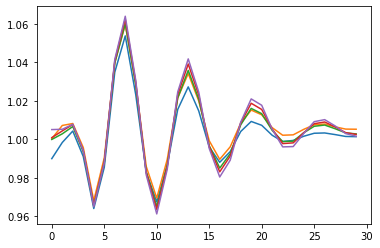

In [58]:
# Get mean of pk for bao and nobao for all redshifts and save them in one file

all_means_pk = {}
for i,z in enumerate(z_paths):
    means_pk = {}
    pkm,pknm = 0,0
    N = 0 
    pkf,pkn,bao = [],[],[]
    for file in os.listdir(z+"/"+data[0]):
        if file[:2] == "Pk" and os.path.exists(z+"/"+data[0]+"/"+file) and os.path.exists(z+"/"+data[1]+"/"+file):
            pkk1 = np.loadtxt(z+"/"+data[0]+"/"+file)
            k,pk1 = pkk1[:,0],pkk1[:,1]
            pkf.append(pk1)
            pkm = pkm + pk1
                
            pkk2 = np.loadtxt(z+"/"+data[1]+"/"+file)
            k,pk2 = pkk2[:,0],pkk2[:,1]
            pkn.append(pk2)
            pknm = pknm + pk2
            bao.append(pk1/pk2)
            N+=1
            # print(z+"/"+data[0]+"/"+file,z+"/"+data[1]+"/"+file)
    print(z,N)
    pkm = pkm/N
    pknm = pknm/N
    means_pk[data[0]] = pkm
    means_pk[data[1]] = pknm
    plt.plot(pkm/pknm)
    # np.savez("/global/homes/s/shreeb/BAO_bispectrum/nobao_project/data/withbao_glam/pk_"+zs[i]+"_0"+str(i+1)+".npz", k = k, pkm = pkm, pknm = pknm, pk_baom = pkm/pknm, pk = np.array(pkf).T, pkn = np.array(pkn).T, pk_bao = np.array(bao).T) 
    all_means_pk[zs[i]] = means_pk

# np.save(outpath+"means_pk.npy",all_means_pk)

In [59]:
def smoothPk(k,A0,keq,a0,a2,a4,n):
    k = np.array(k)
    q = k/keq
    L = np.log(2*np.exp(1)+1.8*q)
    C = 14.2+731/(1+62.5*q)
    T = L/(L+C*(q**2))
    return A0*(a0+(T**2)*(k**n))

data_path = "/pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/data/camb_new/camb_python/"
outpaths = "/pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/data/camb_new/camb_python_smooth/"

def get_smooth(inpaths,outpaths = None):
    Ps = lambda k,A0,keq,a0,a2,a4,n : smoothPk(k,A0,keq,a0,a2,a4,n)
    p0 = [30000,0.05,0,0,0,2]
    for file in os.listdir(inpaths):
        if file[-3:] == "dat":
            # print(file)
            pkk = np.loadtxt(inpaths+file)
            h = int(file[5:9])/10000
            pk = pkk[:,1]
            k = pkk[:,0]*h
            popt, _ = curve_fit(Ps, k ,pk, p0, (1/k)**2, maxfev=100000)
            smooth_pk = Ps(k,*popt)
            plt.plot(k,pk/smooth_pk)
            # np.savetxt(outpaths+"smooth_"+file, smooth_pk)
            # print(outpaths+"smooth_"+file)
    plt.xlim(0.005,0.3)
    plt.ylim(0.9,1.1)


/tmp/ipykernel_1440715/325913918.py:7: RuntimeWarning: overflow encountered in power
  return A0*(a0+(T**2)*(k**n))
/tmp/ipykernel_1440715/325913918.py:7: RuntimeWarning: overflow encountered in multiply
  return A0*(a0+(T**2)*(k**n))
/global/homes/s/shreeb/anaconda3/envs/bispectrum/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


NameError: name 'k' is not defined

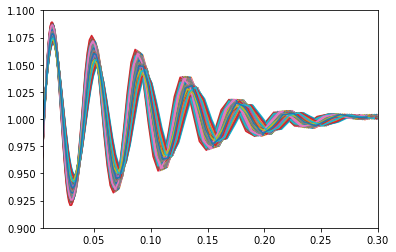

In [47]:
get_smooth(data_path,outpaths)
plt.loglog(k,pkm/pknm)

In [23]:
# # Get mean of pk for bao and nobao for all redshifts and save them in one file

# all_means_pk = {}
# for i,z in enumerate(z_paths):
#     means_pk = {}
#     for d in data:
#         mean_pk = 0
#         N = 0 
#         all_pk = []
#         for file in os.listdir(z+"/"+d):
#             if file[:2] == "Pk":
#                 # print(file)
#                 pkk = np.loadtxt(z+"/"+d+"/"+file)
#                 k,pk = pkk[:,0],pkk[:,1]
#                 all_pk.append(pk)
#                 mean_pk = mean_pk + pk
#                 N+=1
#         print(z,d,N)
#         mean_pk = mean_pk/N
#         if d == "BAO":
#             pkm = mean_pk
#             pkf = all_pk
#         elif d == "noBAO":
#             pknm = mean_pk
#             pkn = all_pk
#         means_pk[d] = mean_pk
#     # np.savez("/global/homes/s/shreeb/BAO_bispectrum/nobao_project/data/glam/pk_"+zs[i]+".npz", k = k, pkm = pkm, pknm = pknm, pk = np.array(pkf).T, pkn = np.array(pkn).T) 
#     all_means_pk[zs[i]] = means_pk

# # np.save(outpath+"means_pk.npy",all_means_pk)
                

['k', 'pkm', 'pknm', 'pk_baom', 'pk', 'pkn', 'pk_bao']


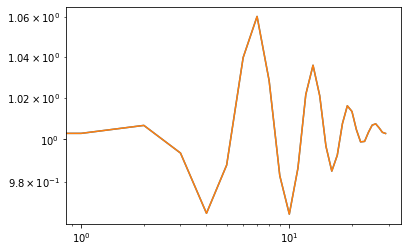

In [24]:
power = np.load("/global/homes/s/shreeb/BAO_bispectrum/nobao_project/data/withbao_glam/pk_z0.50_03.npz")
power1 = np.load("/global/homes/s/shreeb/BAO_bispectrum/nobao_project/data/withbao_glam/pk_z0.0_01.npz")
print(power.files)

power_mehdi = np.load("/global/homes/s/shreeb/BAO_bispectrum/nobao_project/data/glam/pk_z0.50_mehdi.npz")
plt.loglog(power["pkm"]/power["pknm"])
plt.loglog(power["pk_baom"])
# plt.plot(power_mehdi["pkm"]/power_mehdi["pknm"])
# plt.plot(power_mehdi["pkm"].T[0]/power_mehdi["pknm"].T[0])

In [25]:
# Get best smooth fit for each
popts = []
for i in range(len(zs)):
    pk = all_means_pk[zs[i]]["BAO"]
    Ps = lambda k,A0,keq,a0,a2,a4,n : smoothPk(k,A0,keq,a0,a2,a4,n)
    p0 = [30000,0.05,0,0,0,2]
    popt, _ = curve_fit(Ps, k ,pk, p0, (1/k)**2, maxfev=100000)
    popts.append(popt)

/tmp/ipykernel_1030412/325913918.py:4: RuntimeWarning: invalid value encountered in log
  L = np.log(2*np.exp(1)+1.8*q)


Text(0.5, 0, '$k [h/Mpc]$')

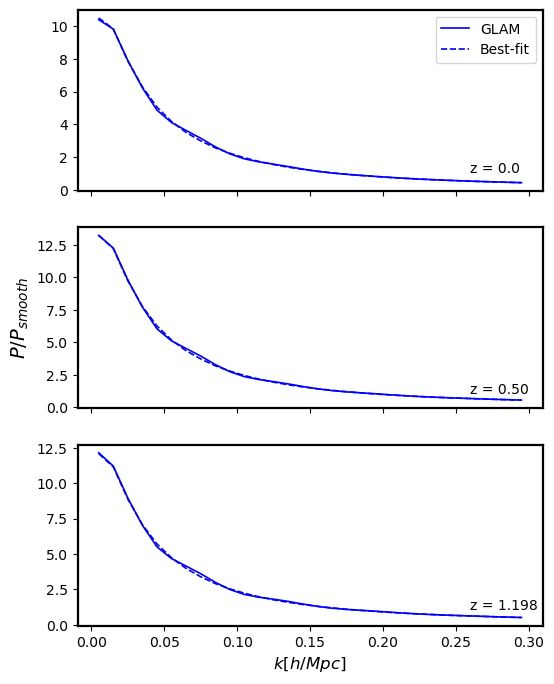

In [331]:
# load and plot
# all_means_pk = np.load(outpath+"means_pk.npy", allow_pickle = True).item()
fig, ax = plt.subplots(3,sharex=True, figsize = (6,8))
# plt.figure(figsize = (16,8))

for axis in ['top','bottom','left','right']:
    ax[0].spines[axis].set_linewidth(1.6)
    ax[1].spines[axis].set_linewidth(1.6)
    ax[2].spines[axis].set_linewidth(1.6)

for i in range(0,len(zs),2):
    ind = int(i/2)

    # wiggles = all_means_pk[zs[i]]["BAO"]/all_means_pk[zs[i]]["noBAO"]
    # bf_wiggles = all_means_pk[zs[i]]["BAO"]/smoothPk(k,*popts[i])
    # plt.plot(k,smoothPk(k,*popts[i]))
    # plt.plot(k,all_means_pk[zs[i]]["BAO"])
    ax[ind].plot(k,all_means_pk[zs[i]]["BAO"],color = "blue",linewidth = 1.2,label = "GLAM")
    ax[ind].plot(k,all_means_pk[zs[i]]["noBAO"],"--" ,linewidth = 1.2, color = "blue", label = "Best-fit")
    ax[ind].text(0.26, 1.08,str(zs[i][0])+ " = "+ str(zs[i][1:]), fontsize = 10)
    # ax[ind].set_ylim(0.9,1.1)
ax[0].legend(loc = "upper right")
ax[1].set_ylabel(r'$P / P_{smooth}$', fontsize = 14)
plt.xlabel(r"$k [h/Mpc]$", fontsize= 12)


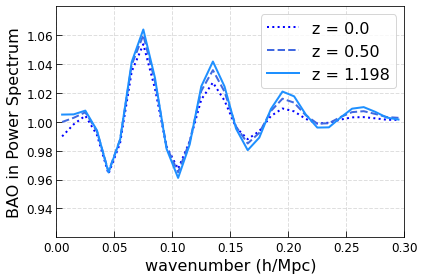

In [61]:
colors = ["blue","royalblue","dodgerblue"]
linestyles = ['-',"--",":"]
linestyles.reverse()
for i in range(0,len(zs),2):
    ind = int(i/2)
    wiggles = all_means_pk[zs[i]]["BAO"]/all_means_pk[zs[i]]["noBAO"]
    plt.plot(k,wiggles,linewidth = 2,color = colors[ind], linestyle = linestyles[ind],label =str(zs[i][0])+ " = "+ str(zs[i][1:]))
plt.xlabel('wavenumber (h/Mpc)', fontsize=16)
plt.ylabel('BAO in Power Spectrum', fontsize=16)
plt.xlim([0, 0.3])
plt.xticks([0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30])
plt.ylim([0.92, 1.08])
plt.yticks(np.arange(0.94, 1.06, step=0.02))
plt.tick_params(direction='in', size=6, labelsize=12)
plt.legend(fontsize=16)
plt.grid(True, alpha=0.4, linewidth=1, linestyle='--')
plt.tight_layout()
# plt.savefig('plots_new/BAO_pk.png', dpi=200)

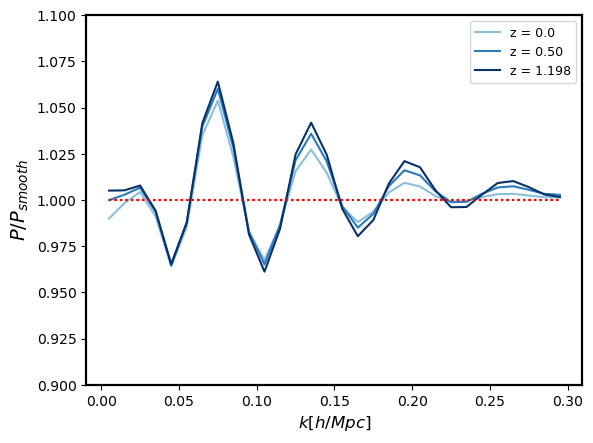

In [52]:
import matplotlib.cm as cm
colors = cm.Blues(np.linspace(0,1,8))
fig, ax = plt.subplots()
# plt.figure(figsize = (16,8))

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.6)
    
for i in range(0,len(zs),2):
    wiggles = all_means_pk[zs[i]]["BAO"]/all_means_pk[zs[i]]["noBAO"]
    ax.plot(k,wiggles,linewidth = 1.5,color = colors[i+3],label =str(zs[i][0])+ " = "+ str(zs[i][1:]))
    ax.plot(k, [1]*len(k),":",color = "red")
    ax.set_ylim(0.9,1.1)
plt.ylabel(r'$P / P_{smooth}$', fontsize = 14)
plt.xlabel(r"$k [h/Mpc]$", fontsize= 12)
plt.legend(fontsize = 9)
# plt.savefig("plots/glampk_zs.png", dpi = 150)

In [67]:
import pyclass
from cosmoprimo.fiducial import Planck2018FullFlatLCDM, AbacusSummit, DESI, TabulatedDESI
cosmop = Planck2018FullFlatLCDM(engine = "class")
cosmo = Cosmology(engine = "class")
cosmo_custom = Cosmology(h = 0.6777, Omega_m=0.307, Omega_b = 0.04825, sigma8=1000, engine = "class")

print('One can provide the following parameters (including conflicts):',
      cosmop.get_default_params(include_conflicts=True))

print('Omega_m', cosmop['Omega_m'], cosmo_custom['Omega_m'])
print('Omega_cdm', cosmop['Omega_cdm'], cosmo_custom['Omega_cdm'])
print('Omega_b', cosmop['Omega_b'], cosmo_custom['Omega_b'], cosmo_custom['omega_b'])
print('h', cosmop['h'], cosmo_custom['h'])


One can provide the following parameters (including conflicts): {'h': 0.7, 'Omega_cdm': 0.25, 'Omega_b': 0.05, 'Omega_k': 0.0, 'sigma8': 0.8, 'k_pivot': 0.05, 'n_s': 0.96, 'alpha_s': 0.0, 'beta_s': 0.0, 'r': 0.0, 'n_t': 'scc', 'alpha_t': 'scc', 'T_cmb': 2.7255, 'm_ncdm': None, 'neutrino_hierarchy': None, 'T_ncdm_over_cmb': 0.71611, 'N_eff': 3.044, 'tau_reio': 0.06, 'reionization_width': 0.5, 'A_L': 1.0, 'w0_fld': -1.0, 'wa_fld': 0.0, 'cs2_fld': 1.0, 'H0': 0.7, 'omega_cdm': 0.25, 'Omega0_cdm': 0.25, 'Omega_c': 0.25, 'omega_c': 0.25, 'Omega_m': 0.25, 'omega_m': 0.25, 'Omega0_m': 0.25, 'omega_b': 0.05, 'Omega0_b': 0.05, 'A_s': 0.8, 'logA': 0.8, 'ln10^{10}A_s': 0.8, 'ln10^10A_s': 0.8, 'Omega_g': 2.7255, 'omega_g': 2.7255, 'Omega0_g': 2.7255, 'Omega_ncdm': None, 'omega_ncdm': None, 'Omega0_ncdm': None, 'N_ur': 3.044, 'Omega_ur': 3.044, 'omega_ur': 3.044, 'Omega0_ur': 3.044, 'z_reio': 0.06, 'non_linear': '', 'modes': 's', 'lensing': False, 'z_pk': None, 'kmax_pk': 10.0, 'ellmax_cl': 2500, 'Y

[10.37572487  9.80183628  7.88796624  6.22492829  4.86883338  4.11334864
  3.63360057  3.16152739  2.63739753  2.20992662  1.9068888   1.72453202
  1.58407705  1.43991858  1.28599377  1.15012657  1.04456073  0.96528787
  0.90040779  0.83939678  0.77964444  0.72482982  0.67653041  0.63573617
  0.6000456   0.56717612  0.53699323  0.50883121  0.48286273  0.45939833]
[33.01969392 32.41629252 15.12827048  5.15704644  1.75886316  1.58570239
  1.87473577  2.32028248  2.57552433  2.51863776  2.26326229  1.96843089
  1.70546791  1.470786    1.28191233  1.14076989  1.03639276  0.95539177
  0.88637348  0.82722079  0.77483732  0.72643843  0.68161061  0.64015085
  0.60244622  0.56814795  0.53689117  0.50854751  0.48280186  0.45934778]
[13.23193237 12.25595536  9.80136397  7.71374685  6.04132948  5.11637458
  4.53120341  3.95196624  3.29563986  2.74828951  2.3689046   2.14634163
  1.9859681   1.80962756  1.61219936  1.43410921  1.29783012  1.20101217
  1.12553009  1.05182344  0.97635282  0.90374558 

Text(0, 0.5, 'BAO in Power Spectrum')

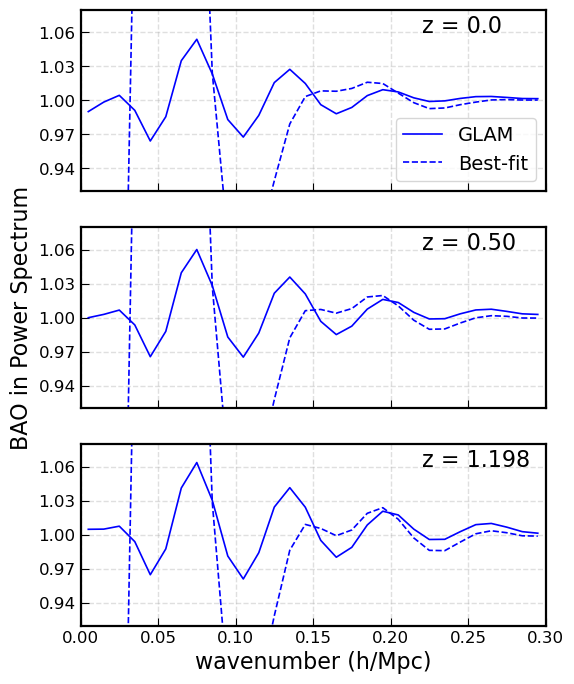

In [75]:
# load and plot
# all_means_pk = np.load(outpath+"means_pk.npy", allow_pickle = True).item()
fig, ax = plt.subplots(3,sharex=True, sharey = True, figsize = (6,8))
# plt.figure(figsize = (16,8))

for axis in ['top','bottom','left','right']:
    ax[0].spines[axis].set_linewidth(1.6)
    ax[1].spines[axis].set_linewidth(1.6)
    ax[2].spines[axis].set_linewidth(1.6)

for i in range(0,len(zs),2):
    ind = int(i/2)
    h = 1
    pk_interpolator = PowerSpectrumInterpolator1D(np.hstack([0.001 ,k]), np.hstack([0.001, all_means_pk[zs[i]]["BAO"]]))
    # pk_interpolator = PowerSpectrumInterpolator1D(k, all_means_pk[zs[i]]["BAO"])
    # print(all_means_pk[zs[i]]["BAO"] )
    pk_smooth_interpolator = PowerSpectrumBAOFilter(pk_interpolator, engine='wallish2018').smooth_pk_interpolator()
    # pk_smooth_interpolator = PowerSpectrumBAOFilter(pk_interpolator, engine='peakaverage', cosmo=cosmo, cosmo_fid=cosmo).smooth_pk_interpolator()
    # pk_smooth_interpolator = PowerSpectrumBAOFilter(pk_interpolator, engine='brieden2022',cosmo=cosmo, cosmo_fid=cosmo).smooth_pk_interpolator()
    bf_wiggles = all_means_pk[zs[i]]["BAO"]/pk_smooth_interpolator(k)
    wiggles = all_means_pk[zs[i]]["BAO"]/all_means_pk[zs[i]]["noBAO"]
    # print(pk_smooth_interpolator(k))
    # print(pk_smooth_interpolator(k))
    # bf_wiggles = all_means_pk[zs[i]]["BAO"]/smoothPk(k,*popts[i])
    # plt.plot(k,smoothPk(k,*popts[i]))
    # plt.plot(k,all_means_pk[zs[i]]["BAO"])
    ax[ind].plot(k,wiggles,color = "blue",linewidth = 1.2,label = "GLAM")
    ax[ind].plot(k,bf_wiggles,linewidth = 1.2, color = "blue", linestyle = '--', label = "Best-fit")
    ax[ind].text(0.22, 1.06,str(zs[i][0])+ " = "+ str(zs[i][1:]), fontsize = 16)
    ax[ind].set_xlim([0, 0.3])
    ax[ind].set_xticks([0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30])
    ax[ind].set_ylim([0.92, 1.08])
    ax[ind].set_yticks(np.arange(0.94, 1.08, step=0.03))
    ax[ind].tick_params(direction='in', size=6, labelsize=12)
    ax[ind].grid(True, alpha=0.4, linewidth=1, linestyle='--')
# plt.tight_layout()
ax[0].legend(loc = "lower right", fontsize = 14)
plt.xlabel('wavenumber (h/Mpc)', fontsize=16)
ax[1].set_ylabel('BAO in Power Spectrum', fontsize=16)
# plt.savefig("plots_new/Pks_zs.png", dpi = 300)


0.6577
0.7027
0.6777


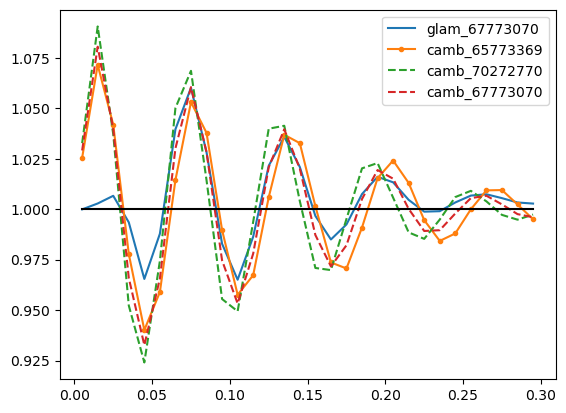

In [69]:
# info_path = "/global/homes/s/shreeb/BAO_bispectrum/nobao_project/data/camb_final/"
# mcmc_path = "/global/homes/s/shreeb/BAO_bispectrum/nobao_project/all_mcmc_results/mcmc_camb_final/"

info_path = "/pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/data/camb_new/camb_python_info/"
mcmc_path = "/pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/all_mcmc_results/new_alpha/glam_parallel_kmax02/"
data_path = "/pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/"

reader = emcee.backends.HDFBackend(mcmc_path + "mcmc_camb_65773369_matterpower_z0.5_0021.h5",read_only=True)
flat_samples = reader.get_chain(discard=800, thin=15, flat=True)
E1 = np.mean(flat_samples[:,1])
alpha_bf1 = np.mean(flat_samples[:,0])
# print("GLAM 67773070:", all_atrue[60],all_amodel[60], all_rs[60])
# print("CAMB 65773369:", all_atrue[21],alpha_bf1, all_rs[21], E1)
reader = emcee.backends.HDFBackend(mcmc_path + "mcmc_camb_70272770_matterpower_z0.5_0110.h5",read_only=True)
flat_samples = reader.get_chain(discard=800, thin=15, flat=True)
E2 = np.mean(flat_samples[:,1])
alpha_bf2 = np.mean(flat_samples[:,0])
# print("CAMB 70272770:", all_atrue[110],alpha_bf2,all_rs[110], E2)

rscamb = np.load(info_path + "infocamb_67772890_matterpower_z0.5_0057.npy", allow_pickle=True).item()["rdrag"]
rsglam = np.load(info_path + "infocamb_67773070_matterpower_z0.5_0060.npy", allow_pickle=True).item()["rdrag"]
alpha_true = (rsglam/rscamb)#/(all_dv[60]/all_dv[57])
# print(rsglam,all_rs[60],all_dv[60])


Bk=np.load("../Molino_mocks/bk_molino_z0.npz")
Pk=np.load("../Molino_mocks/pk_molino_z0.npz")
k,pk0,pk2,pk4=Pk['k'], Pk['pk0'], Pk['pk2'], Pk['pk4']
kk,bk0,bk2,bk4=Bk['kk'], Bk['bk0'], Bk['bk2'], Bk['bk4']
# pkm=np.mean(pk0,axis=1)
# bkm=np.mean(bk0,axis=1)

Bk=np.load("data/withbao_glam/bk_z0.50_03.npz")
Pk=np.load("data/withbao_glam/pk_z0.50_03.npz")
k,pkm,pknm,pk,pkn=Pk['k'], Pk['pkm'],Pk['pknm'],Pk['pk'],Pk['pkn']
kk,bkm,bknm,bk,bkn=Bk['kk'], Bk['bkm'], Bk['bknm'],Bk['bk'],Bk['bkn']

glamw = pkm/pknm

def prepare_pk(k,E,use_glam = False,filepath = None):
    if use_glam == False:
        pkcamb = np.loadtxt(filepath)
        h = int(pathlib.PurePath(filepath).name[5:9])/10000
        print(h)
        # pkcamb[:,1] = pkcamb[:,1]/np.mean(pkcamb[:,1]) * np.mean(pkm)
        fpk,pknmf,pkmf = less_baoPk(pkcamb,k,h,E, method = "cosmoprimo")
        
        # pknmf = pknmf/np.mean(pknmf) * np.mean(pkm)
        # pkmf = pkmf/np.mean(pkmf) * np.mean(pknm)
    else:
        pkmf = pkm
        pknmf = pknm
        fpk = pkm
    
    return k,fpk,pkmf,pknmf


kc,fpk1,pkmc1,pknmc1 = prepare_pk(k, E1,use_glam = False, filepath = data_path+"data/camb_new/camb_python/camb_65773369_matterpower_z0.5_0021.dat")
kc,fpk2,pkmc2,pknmc2 = prepare_pk(k, E2,use_glam = False, filepath = data_path+"data/camb_new/camb_python/camb_70272770_matterpower_z0.5_0110.dat")
kc,fpk3,pkmc3,pknmc3 = prepare_pk(k, E2,use_glam = False, filepath = data_path+"data/camb_new/camb_python/camb_67773070_matterpower_z0.5_0060.dat")


plt.plot(kc,pkm/pknm, label = "glam_67773070")
plt.plot(kc,pkmc1/pknmc1, ".-", label = "camb_65773369")
plt.plot(kc,pkmc2/pknmc2, "--", label = "camb_70272770" )
plt.plot(kc,pkmc3/pknmc3, "--", label = "camb_67773070" )

plt.plot(kc,np.ones(len(kc)), "black")
# plt.ylim(0.8,1.2)

plt.legend()

# np.savetxt(data_path+"data/camb_new/camb_67773070_matterpower_z0.5_0060_smooth.dat", pknmc)

# fpka,pkmca,pknmca = prepare_pk(k*0.97,E,use_glam = False)
# fpkat,pkmcat,pknmcat = prepare_pk(k*0.97690945,E,use_glam = False)

# cambw = fpk/pknmc
# cambrw = pkmc/pknmc
# cambwa = pkmca/pknmca
# cambwat = pkmcat/pknmcat

# cambrwa = np.interp(k*alpha_bf,k,cambrw)
# cambrwat = np.interp(k*alpha_true,k,cambrw)

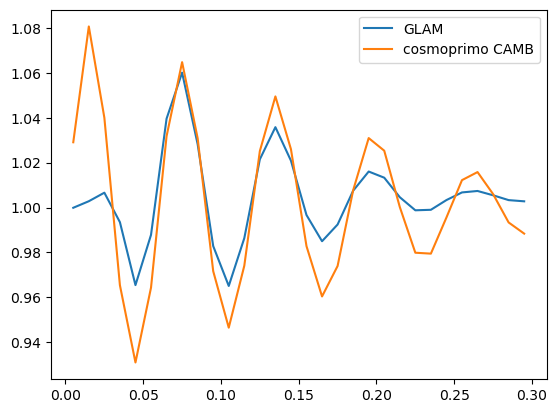

In [334]:
import numpy as np
import matplotlib.pyplot as plt
from cosmoprimo import *

Pk=np.load("data/withbao_glam/pk_z0.50_03.npz")
k,pkm,pknm,pk,pkn=Pk['k'], Pk['pkm'],Pk['pknm'],Pk['pk'],Pk['pkn']

pkcamb = np.loadtxt(data_path+"data/camb_new/camb_python/camb_67773070_matterpower_z0.5_0060.dat")
pk_interpolator = PowerSpectrumInterpolator1D(pkcamb[:,0],pkcamb[:,1])
pknow_wallish = PowerSpectrumBAOFilter(pk_interpolator, engine='wallish2018').smooth_pk_interpolator()

plt.plot(k,pkm/pknm, label = "GLAM")
plt.plot(k,pk_interpolator(k)/pknow_wallish(k), label = "cosmoprimo CAMB")
plt.legend()

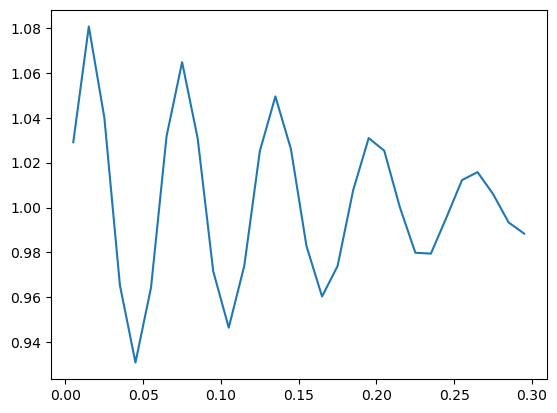

In [36]:
plt.plot(k,pk_interpolator(k)/pknow_wallish(k))

NameError: name 'alpha_bf' is not defined

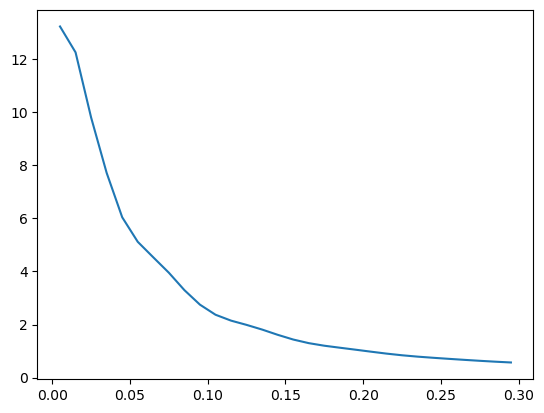

In [68]:
# plt.plot(k,fpk)
plt.plot(k,pkm, label = "GLAM meas")
plt.plot(k,np.interp(k*alpha_bf,k,pkmc),label = r"CAMB $(k\alpha_{bestfit})$")
plt.plot(k,np.interp(k*alpha_true,k,pkmc),label = r"CAMB $(k\alpha_{true})$")
plt.xlabel("k")
plt.ylabel(r"Power spectrum")
plt.legend()

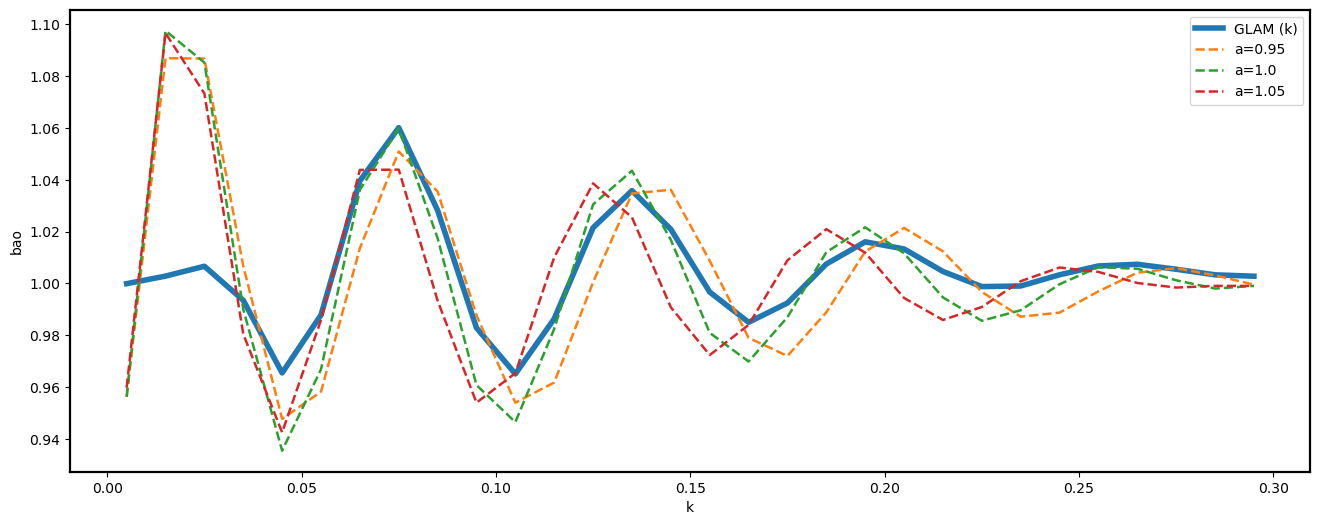

In [58]:
fig, ax = plt.subplots(sharex=True, sharey = True, figsize = (16,6))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.6)

ax.plot(k,glamw,linewidth = 4,label = "GLAM (k)")
# ax.plot(k,cambrwa,linewidth = 2,label = r"Reduced bao CAMB $(k\alpha_{bestfit})$")
a_list = np.round(np.arange(0.95,1.05,0.05),4)
for a in a_list:
    ax.plot(k,np.interp(k*a,k,cambrw),"--",linewidth = 1.8,label = f"a={a}")
plt.xlabel("k")
plt.ylabel("bao")
plt.legend()
# ax.plot(k,cambrwat,linewidth = 2,label = r"Reduced bao CAMB $(k\alpha_{true})$")

Text(0, 0.5, 'BAO in Power Spectrum')

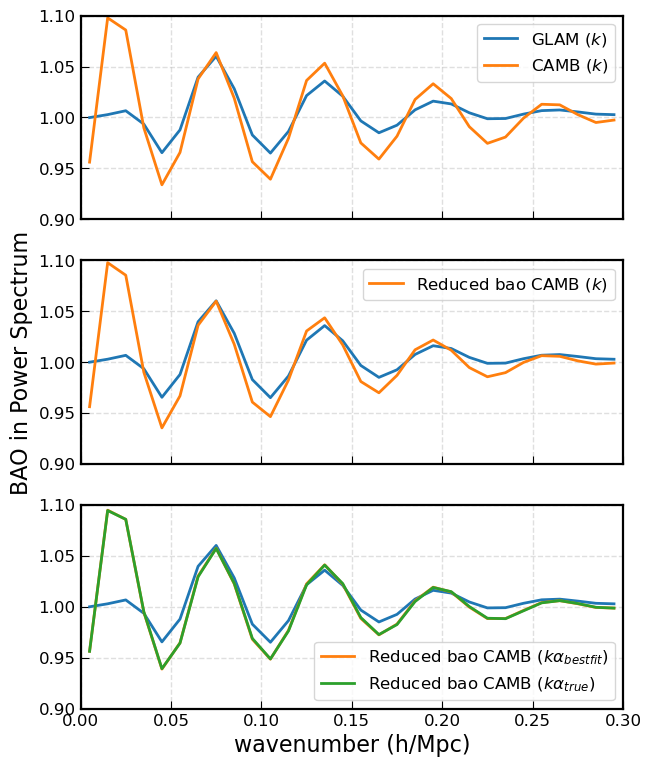

In [59]:
# plt.figure(figsize=(12,5))
fig, ax = plt.subplots(3,sharex=True, sharey = True, figsize = (7,9))
for axis in ['top','bottom','left','right']:
    ax[0].spines[axis].set_linewidth(1.6)
    ax[1].spines[axis].set_linewidth(1.6)
    ax[2].spines[axis].set_linewidth(1.6)
    
ax[0].plot(k,glamw,linewidth = 2,label = "GLAM $(k)$")
ax[0].plot(k,cambw, linewidth = 2,label = "CAMB $(k)$")

ax[1].plot(k,glamw,linewidth = 2) #,label = "GLAM $(k)$")
ax[1].plot(k,cambrw,linewidth = 2,label = "Reduced bao CAMB $(k)$")

ax[2].plot(k,glamw,linewidth = 2) #,label = "GLAM (k)")
ax[2].plot(k,cambrwa,linewidth = 2,label = r"Reduced bao CAMB $(k\alpha_{bestfit})$")
ax[2].plot(k,cambrwat,linewidth = 2,label = r"Reduced bao CAMB $(k\alpha_{true})$")

ax[0].set_xlim([0, 0.3])
ax[0].set_xticks([0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30])
ax[0].set_ylim([0.9, 1.1])
ax[0].set_yticks(np.arange(0.9, 1.1, step=0.05))
ax[0].tick_params(direction='in', size=6, labelsize=12)
ax[0].legend(fontsize=12)
ax[0].grid(True, alpha=0.4, linewidth=1, linestyle='--')

ax[1].set_xlim([0, 0.3])
ax[1].set_xticks([0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30])
ax[1].set_ylim([0.9, 1.1])
ax[1].set_yticks(np.arange(0.9, 1.1, step=0.05))
ax[1].tick_params(direction='in', size=6, labelsize=12)
ax[1].legend(fontsize=12)
ax[1].grid(True, alpha=0.4, linewidth=1, linestyle='--')

ax[2].set_xlim([0, 0.3])
ax[2].set_xticks([0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30])
ax[2].set_ylim([0.9, 1.1])
ax[2].set_yticks(np.arange(0.9, 1.1, step=0.05))
ax[2].tick_params(direction='in', size=6, labelsize=12)
ax[2].legend(fontsize=12)
ax[2].grid(True, alpha=0.4, linewidth=1, linestyle='--')

# plt.tight_layout()
plt.xlabel('wavenumber (h/Mpc)', fontsize=16)
ax[1].set_ylabel('BAO in Power Spectrum', fontsize=16)
# ax[1].set_ylabel(r'$P / P_{smooth}$', fontsize = 14)
# plt.savefig("plots/pk_camb_alpha_mod.png",dpi = 300)

### Bispectrum

- ##### Mean pure BAO vs the best-fit model for GLAM power at  different redshifts with :
        - Same cosmology
        - Wrong cosmology corrected by alpha

- ##### MCMC chains showing consistency of alpha at z = 0.5 and z = 0.0.
- ##### 2 mcmc plots with and without gaussian parameter, sigma.
- ##### One plot showing imposing priors doesn't make a difference
- ##### Systematic offset in omegam (fixed omegab) vs H0 plane.




In [2]:
import pandas as pd

In [6]:
import os
z_paths = [i[0] for i in os.walk('/pscratch/sd/s/shreeb/shreeb/GLAM_Bi/') if i[0].split("/")[-1].startswith("z")]
z_paths = sorted(z_paths, key=lambda x: os.path.basename(os.path.normpath(x))[1:])
print(z_paths)
zs = [os.path.basename(os.path.normpath(path)) for path in z_paths]
data = ["BAO","noBAO"]
outpath = "/pscratch/sd/s/shreeb/shreeb/GLAM_Bi/all_zs/"
zs

['/pscratch/sd/s/shreeb/shreeb/GLAM_Bi/z0.0', '/pscratch/sd/s/shreeb/shreeb/GLAM_Bi/z0.197', '/pscratch/sd/s/shreeb/shreeb/GLAM_Bi/z0.5', '/pscratch/sd/s/shreeb/shreeb/GLAM_Bi/z0.50', '/pscratch/sd/s/shreeb/shreeb/GLAM_Bi/z0.65', '/pscratch/sd/s/shreeb/shreeb/GLAM_Bi/z0.73', '/pscratch/sd/s/shreeb/shreeb/GLAM_Bi/z1.198']


['z0.0', 'z0.197', 'z0.5', 'z0.50', 'z0.65', 'z0.73', 'z1.198']

In [7]:
all_means_bk = {}
for i,z in enumerate(z_paths):
    print(z)
    means_bk = {}
    bkm,bknm = 0,0
    N = 0 
    bkf,bkn,bao = [],[],[]
    for file in os.listdir(z+"/"+data[1]):
        if file[:2] == "Bk" and os.path.exists(z+"/"+data[0]+"/"+file) and os.path.exists(z+"/"+data[1]+"/"+file):
            bkk1 = np.loadtxt(z+"/"+data[0]+"/"+file)
            bkk2 = np.loadtxt(z+"/"+data[1]+"/"+file)
            if len(bkk1.shape)==2 and len(bkk2.shape)==2:
                kk,bk1 = bkk1[:,0:3],bkk1[:,3]
                bkf.append(bk1)
                bkm = bkm + bk1
                
                kk,bk2 = bkk2[:,0:3],bkk2[:,3]
                bkn.append(bk2)
                bknm = bknm + bk2
                bao.append(bk1/bk2)
                # plt.plot(bao)
                N+=1
            # print(z+"/"+data[0]+"/"+file,z+"/"+data[1]+"/"+file)
    print(N)
    bkm = bkm/N
    bknm = bknm/N
    # plt.plot(bkm/bknm, label = zs[i])
    # plt.legend()
    means_bk[data[0]] = bkm
    means_bk[data[1]] = bknm
    # np.savez("/global/homes/s/shreeb/BAO_bispectrum/nobao_project/data/withbao_glam/bk_"+zs[i]+"_0"+str(i+1)+".npz", kk = kk, bkm = bkm, bknm = bknm, bk_baom = bkm/bknm, bk = np.array(bkf).T, bkn = np.array(bkn).T, bk_bao = np.array(bao).T) 
    all_means_bk[zs[i]] = means_bk
# plt.ylim(0.75,1.25)

/pscratch/sd/s/shreeb/shreeb/GLAM_Bi/z0.0
655
/pscratch/sd/s/shreeb/shreeb/GLAM_Bi/z0.197


/tmp/ipykernel_1170983/2905041976.py:10: UserWarning: loadtxt: input contained no data: "/pscratch/sd/s/shreeb/shreeb/GLAM_Bi/z0.197/BAO/Bk_CatshortV.0125.0670.DAT"
  bkk1 = np.loadtxt(z+"/"+data[0]+"/"+file)


516
/pscratch/sd/s/shreeb/shreeb/GLAM_Bi/z0.5
93
/pscratch/sd/s/shreeb/shreeb/GLAM_Bi/z0.50
922
/pscratch/sd/s/shreeb/shreeb/GLAM_Bi/z0.65
0


ZeroDivisionError: division by zero

In [13]:
Bk=np.load("data/withbao_glam/bk_z0.50_03.npz")
Pk=np.load("data/withbao_glam/pk_z0.50_03.npz")
k,pkm,pknm,pk,pkn=Pk['k'], Pk['pkm'],Pk['pknm'],Pk['pk'],Pk['pkn']
kk,bkm,bknm,bk,bkn,bao=Bk['kk'], Bk['bkm'], Bk['bknm'],Bk['bk'],Bk['bkn'],Bk['bk_bao']

In [48]:
# # Get mean of bk for bao and nobao for all redshifts and save them in one file

# all_means_bk = {}
# for i,z in enumerate(z_paths):
#     means_bk = {}
#     for d in data:
#         mean_bk = 0
#         N = 0
#         all_bk = []
#         for file in os.listdir(z+"/"+d):
#             if file[:2] == "Bk":
#                 filepath = z+"/"+d+"/"+file
#                 if os.path.getsize(filepath) != 0:
#                     bkk = np.loadtxt(filepath)
#                     kk,bk = bkk[:,0:3],bkk[:,3]
#                     all_bk.append(bk)
#                     mean_bk = mean_bk + bk
#                     N+=1
#         print(z,d,N)
#         mean_bk = mean_bk/N
#         if d == "BAO":
#             bkm = mean_bk
#             bkf = all_bk
#         elif d == "noBAO":
#             bknm = mean_bk
#             bkn = all_bk
#         means_bk[d] = mean_bk
        
#     # np.savez("/global/homes/s/shreeb/BAO_bispectrum/nobao_project/data/glam/bk_"+zs[i]+".npz", kk = kk, bkm = bkm, bknm = bknm, bk = np.array(bkf).T, bkn = np.array(bkn).T) 

#     all_means_bk[zs[i]] = means_bk

# np.save(outpath+"means_bk.npy",all_means_bk)

In [66]:
Bk=np.load("data/withbao_glam/bk_z0.50_03.npz")
Pk=np.load("data/withbao_glam/pk_z0.50_03.npz")
k,pkm,pknm,pk,pkn=Pk['k'], Pk['pkm'],Pk['pknm'],Pk['pk'],Pk['pkn']
kk,bkm,bknm,bk,bkn,bao=Bk['kk'], Bk['bkm'], Bk['bknm'],Bk['bk'],Bk['bkn'],Bk['bk_bao']

Bk_molino=np.load("../Molino_mocks/bk_molino_z0.npz")
bk_mol = Bk_molino["bk0"]

def prepare_pk(k,E,use_glam = False,filepath = None):
    if use_glam == False:
        pkcamb = np.loadtxt(filepath)
        h = int(pathlib.PurePath(filepath).name[5:9])/10000
        print(h)
        # pkcamb[:,1] = pkcamb[:,1]/np.max(pkcamb[:,1]) * np.max(pkm)
        fpk,pknmf,pkmf = less_baoPk(pkcamb,k,E)
        
        # pknmf = pknmf/np.mean(pknmf) * np.mean(pkm)
        # pkmf = pkmf/np.mean(pkmf) * np.mean(pknm)
    else:
        pkmf = pkm
        pknmf = pknm
        fpk = pkm
    
    return k,fpk,pkmf,pknmf

def get_smooth(kk,*args):
    if len(args)==7:
        alpha,f,b1,b2,E,S0,S1 = args
    elif len(args)==6:
        alpha,f,b1,b2,S0,S1 = args
        E = 0
    
    # pk = pk/np.mean(pk)*np.mean(pkm)
    # fpk,pkn = fit_smoothPk(pk,k)
    _,_,pkm,pknm = prepare_pk(k,E,use_glam = False,filepath = "/pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/data/camb_new/camb_python/camb_67773070_matterpower_z0.5_0060.dat" )
    
    pk1=np.interp(alpha*kk[:,0],k,pkm)
    pk2=np.interp(alpha*kk[:,1],k,pkm)
    pk3=np.interp(alpha*kk[:,2],k,pkm)

    pkn1=np.interp(alpha*kk[:,0],k,pknm)
    pkn2=np.interp(alpha*kk[:,1],k,pknm)
    pkn3=np.interp(alpha*kk[:,2],k,pknm)
    
    bfull = np.array(Bi0(alpha*kk,pk1,pk2,pk3,f,b1,b2,S0,S1))
    bsmooth = np.array(Bi0(alpha*kk, pkn1,pkn2,pkn3,f,b1,b2,S0,S1))
    bwiggle = Bi_wiggle(alpha*kk,pk1,pk2,pk3,pkn1,pkn2,pkn3,f,b1,b2,S0,S1)
    
    return bfull,bsmooth,bwiggle

[ 1.00158674  0.0804618   1.7227103  -0.42250389 -0.10747162  0.24285897
 10.09800393]
0.6777


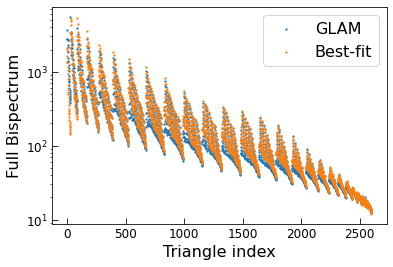

In [65]:
mcmc_path = "/pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/beocat_mcmc_results/mcmc_results_new/mcmc_camb_67773070_matterpower_z0.5_0060.h5" 
''' Normalize camb pk in the above code block if using the beocat mcmc results'''
# mcmc_path = "/global/homes/s/shreeb/BAO_bispectrum/nobao_project/all_mcmc_results/glam_parallel_kmin0/mcmc_glam_z0.50_03_p6.h5"
# mcmc_path = "/pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/all_mcmc_results/new_alpha/glam_parallel_kmax02_params7/mcmc_camb_67773070_matterpower_z0.5_0060.h5"

reader = emcee.backends.HDFBackend(mcmc_path,read_only=True)
flat_samples = reader.get_chain(discard=1000, thin=80, flat=True)
params = np.mean(flat_samples, axis = 0)
print(params)
bfull,bsmooth,bwiggle = get_smooth(kk,*params)
# fig, ax = plt.subplots(figsize = (12,6))
# for axis in ['top','bottom','left','right']:
#     ax.spines[axis].set_linewidth(1.6)

# plt.plot(bkm/bknm,linewidth = 2, label = "True")
# plt.plot(bkm/bsmooth,linewidth = 2, label = "z = 0.50")
# plt.plot(bwiggle,linewidth = 2, label = "Best-fit")

plt.scatter(range(len(bkm)),bkm,s = 1.5,label = "GLAM")
plt.scatter(range(len(bkm)),bfull,s = 1.5,label = "Best-fit")
plt.yscale("log")
# plt.plot(bkm/bsmooth,linewidth = 2, label = "z = 0.50")
plt.ylabel("Full Bispectrum", fontsize = 16)
plt.xlabel("Triangle index", fontsize = 16)
# plt.ylim(-100,5000)
plt.tick_params(direction='in', size=6, labelsize=12)
plt.legend(fontsize = 16)
# plt.savefig("plots_new/glamcamb_bkfull_z05.png",dpi = 300)

[1.00085789 1.80890468 1.16905263 0.95625667 2.41434114 5.6969639
 9.6344011 ]
kmax=0.3, kmin=0, nbins=2600, nmocks=922, hf = -0.5482142857142858
0.6777


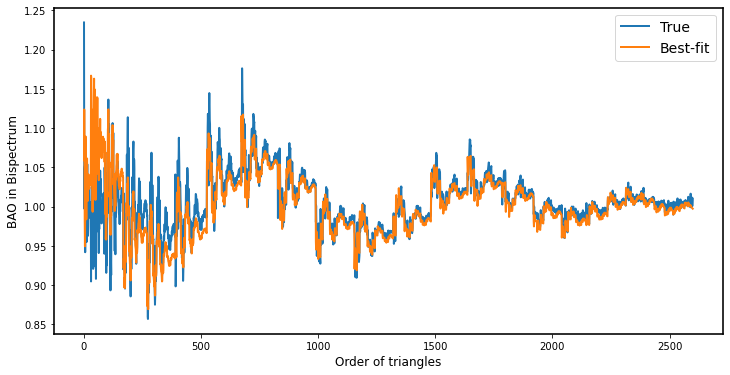

In [67]:
mcmc_path = "/pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/all_mcmc_results/new_alpha/glam_parallel_kmax02_params7/mcmc_camb_67773070_matterpower_z0.5_0060.h5"
reader = emcee.backends.HDFBackend(mcmc_path,read_only=True)
flat_samples = reader.get_chain(discard=1000, thin=80, flat=True)
params = np.mean(flat_samples, axis =0)
print(params)
# cv = [ 1.00608411e+00, -2.37949455e-03, 1.62118558e-02,-7.75032601e-03, 4.07066817e+00 ,-1.68482493e+01, 1.66088250e-02]
# cv[0] = params[0]
# cv[-3] = params[4]
# print(cv)
# params = cv
params[4] = 5
kg,bg,bgn,cov,scaled_cov,_, bao_cov = cutslice(0,0.3,kk,bkm,bk,bknm,bkn,bk_mol,bao)

bfull,bsmooth,bwiggle = get_smooth(kg,*params)
fig, ax = plt.subplots(figsize = (12,6))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.6)

plt.plot(bg/bgn,linewidth = 2, label = "True")
# plt.plot(bkm/bsmooth,linewidth = 2, label = "z = 0.50")
plt.plot(bwiggle,linewidth = 2, label = "Best-fit")

# plt.plot(bkm)
# plt.plot(bfull)
# plt.plot(bkm/bsmooth,linewidth = 2, label = "z = 0.50")
plt.ylabel("BAO in Bispectrum", fontsize = 12)
plt.xlabel("Order of triangles", fontsize = 12)
# plt.ylim(-100,5000)
plt.legend(fontsize = 14)
# plt.savefig("plots_new/glam_bk_z05_E5.png",dpi = 300)

In [68]:
# info_path = "/global/homes/s/shreeb/BAO_bispectrum/nobao_project/data/camb_final/"
# mcmc_path = "/global/homes/s/shreeb/BAO_bispectrum/nobao_project/all_mcmc_results/mcmc_camb_final/"
# file = "mcmc_camb_85488608_matterpower_z0.h5"

camb_path = "/pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/data/camb_new/camb_python/"
info_path = "/pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/data/camb_new/camb_python_info/"
mcmc_path = "/pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/all_mcmc_results/new_alpha/glam_parallel_kmax02/"

index = 57
mcmc_file =  [file for file in os.listdir(mcmc_path) if file.endswith(f"{index:04}.h5")][0]
info_file = [file for file in os.listdir(info_path) if file.endswith(f"{index:04}.npy")][0]
camb_file = [file for file in os.listdir(camb_path) if file.endswith(f"{index:04}.dat")][0]

print(info_file,all_rs[index],all_amodel[index], all_atrue[index], all_rs[index], all_rs[60])

infocamb_67772890_matterpower_z0.5_0057.npy 149.89942026930265 0.9858347817708885 0.9849040438457922 149.89942026930265 147.6365451933761


In [69]:
def getPkforBk(pk,k,kk,alpha = 1):
    '''
    Input : P(k), k, kk
    Output : P(kk)
    '''
    pkk1=np.interp(alpha * kk[:,0],k,pk)
    pkk2=np.interp(alpha * kk[:,1],k,pk)
    pkk3=np.interp(alpha * kk[:,2],k,pk)
    
    return pkk1,pkk2,pkk3


_,f,b1,b2,_,S0,S1 = params
k,fpk,pkmc,pknmc = prepare_pk(k,5,use_glam = False,filepath = camb_path + camb_file )
kg,bg,bgn,cov,scaled_cov,_, bao_cov = cutslice(0,0.3,kk,bkm,bk,bknm,bkn,bk_mol,bao)
print(all_E[index])

0.6777
kmax=0.3, kmin=0, nbins=2600, nmocks=922, hf = -0.5482142857142858
3.5382835909027186


In [70]:
alpha_bf = all_amodel[index]
alpha_true = all_atrue[index]
bglamwt = bg/bgn
bcamb = Bi0(kg,*getPkforBk(fpk,k,kg,alpha = 1),f,b1,b2,S0, S1)
bcambs = Bi0(kg,*getPkforBk(pknmc,k,kg,alpha = 1),f,b1,b2,S0, S1)
bcambr = Bi0(kg,*getPkforBk(pkmc,k,kg,alpha = 1),f,b1,b2,S0, S1)
bcambrs = Bi0(kg,*getPkforBk(pknmc,k,kg,alpha = 1),f,b1,b2,S0, S1)
bcambra = Bi0(kg*alpha_bf,*getPkforBk(pkmc,k,kg,all_amodel[index]),f,b1,b2,S0, S1)
bcambras = Bi0(kg*alpha_bf,*getPkforBk(pknmc,k,kg,all_amodel[index]),f,b1,b2,S0, S1)
bcambrat = Bi0(kg*alpha_true,*getPkforBk(pkmc,k,kg,all_atrue[index]),f,b1,b2,S0, S1)
bcambrats = Bi0(kg*alpha_true,*getPkforBk(pknmc,k,kg,all_atrue[index]),f,b1,b2,S0, S1)

bcambw = bcamb/bcambs
bcambrw = bcambr/bcambrs
bcambrwa = bcambra/bcambras
bcambrwat = bcambrat/bcambrats

(-100.0, 2000.0)

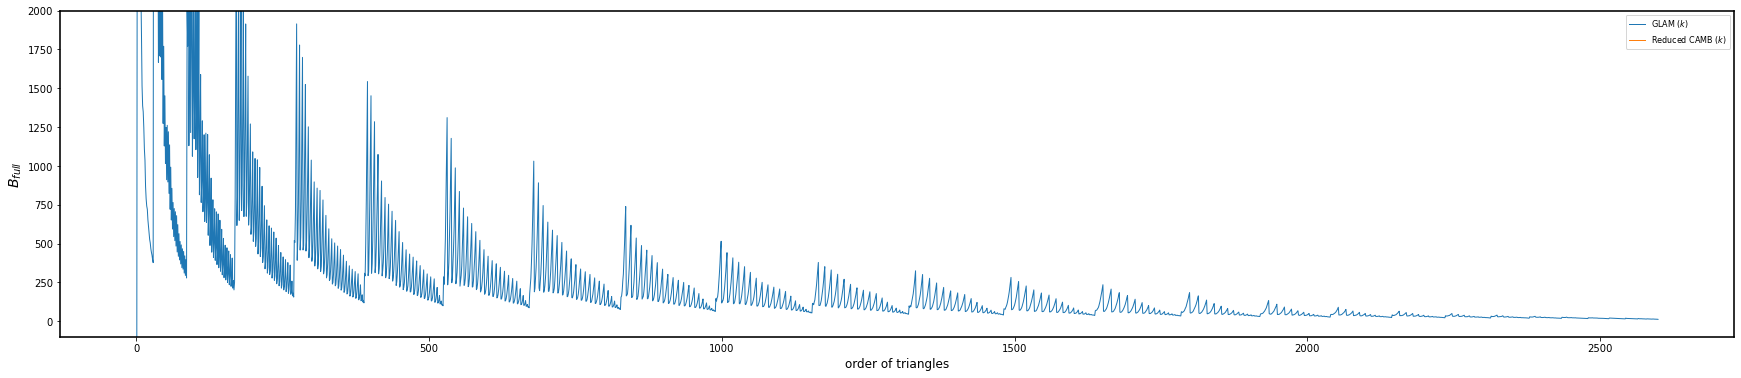

In [58]:
fig, ax = plt.subplots(figsize = (30,6))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.6)

ax.plot(bg, linewidth = 1,label = r"GLAM $(k)$", zorder = 1)
# ax.plot(bcamb, linewidth = 1,label = r"CAMB $(k)$" , zorder = 1)
ax.plot(bcambr,linewidth = 1,label = r"Reduced CAMB $(k)$", zorder = 2)
# ax.plot(bcambra,linewidth = 1,label = r"Reduced CAMB $(k\alpha_{bestfit})$")
# ax.plot(bcambrat,linewidth = 1,label = r"Reduced CAMB $(k\alpha_{true})$")

plt.legend(fontsize = 8)
plt.xlabel("order of triangles", fontsize = 12)
plt.ylabel(r"$B_{full}$", fontsize = 14)
# plt.xscale("log")
plt.ylim(-100,2000)
# plt.xlim(1500,2500)

In [71]:
equi_index = np.where((kg[:,0] == kg[:,1]) & (kg[:,0] == kg[:,2]))
iso_index = np.where((kg[:,0] != kg[:,1]) & (kg[:,1] == kg[:,2]))
all_index = np.where(kg[:,0]>-1)

def marginalize(data1,data2):
    df = pd.DataFrame(np.vstack((data1,data2)).T)
    df1 = df.groupby(0, as_index=False)[1].mean()
    return df1[0],df1[1]
    

(0.6, 1.4)

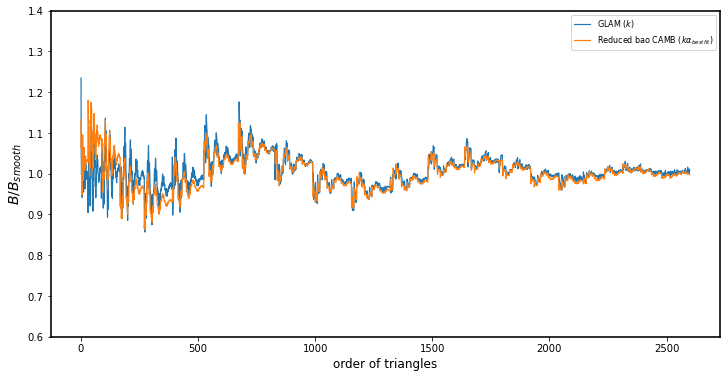

In [60]:
fig, ax = plt.subplots(figsize = (12,6))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.6)

ax.plot(bglamwt, linewidth = 1.2,label = r"GLAM $(k)$")
# ax.plot(bcambw, linewidth = 1.2,label = r"CAMB $(k)$" , zorder = 1)
# ax.plot(bcambrw,linewidth = 1,label = r"Reduced bao CAMB $(k)$")
ax.plot(bcambrwa,linewidth = 1.2,label = r"Reduced bao CAMB $(k\alpha_{bestfit})$")
# ax.plot(bcambrwat,linewidth = 1.2,label = r"Reduced bao CAMB $(k\alpha_{true})$")

plt.legend(fontsize = 8)
plt.xlabel("order of triangles", fontsize = 12)
plt.ylabel(r"$B/B_{smooth}$", fontsize = 14)
plt.ylim(0.6,1.4)

2600
30
435


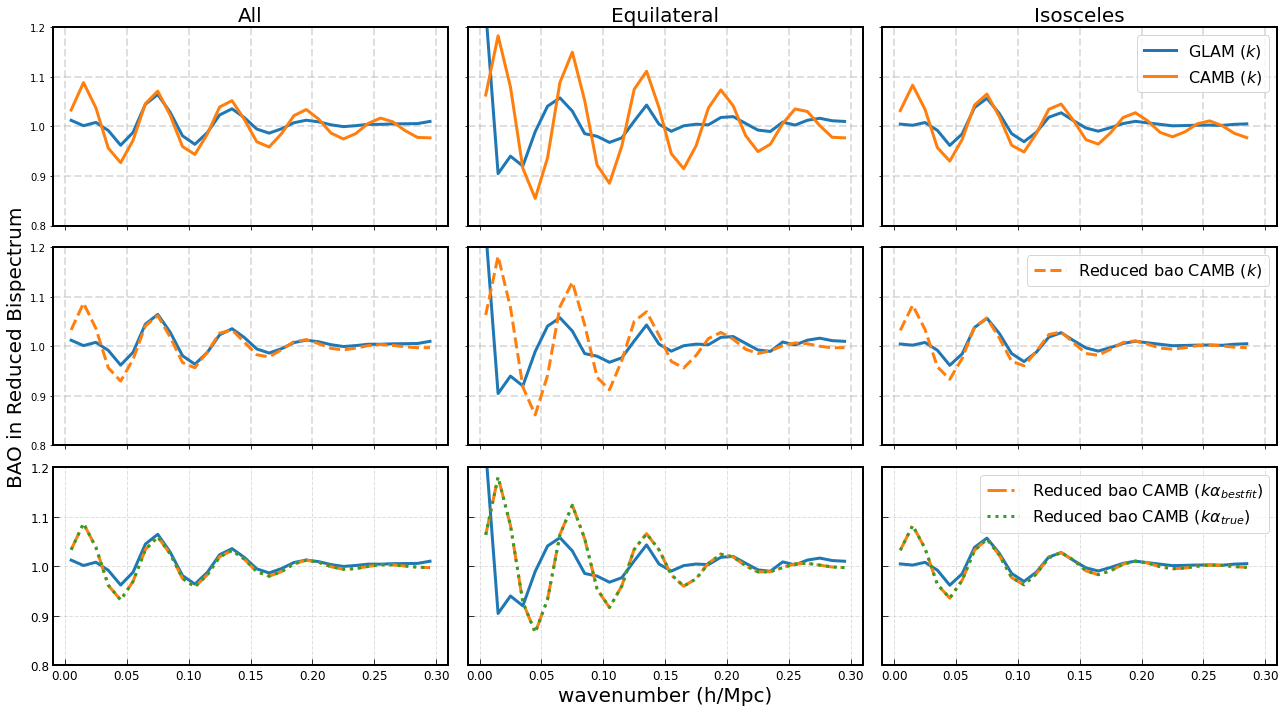

In [72]:
fig, ax = plt.subplots(3,3,sharex=True, sharey = True, figsize = (18,10))
props = dict(boxstyle='square', facecolor='wheat', alpha=0.5)
kconfig = {"All" : all_index, "Equilateral" : equi_index, "Isosceles" : iso_index}

k = 0
for conf, ind in kconfig.items():
    print(len(ind[0]))
    for axis in ['top','bottom','left','right']:
        ax[0,k].spines[axis].set_linewidth(2)
        ax[1,k].spines[axis].set_linewidth(2)
        ax[2,k].spines[axis].set_linewidth(2)

    ax[0,k].plot(*marginalize(kg[ind][:,0],bglamwt[ind]), linewidth = 3,label = r"GLAM $(k)$")
    ax[1,k].plot(*marginalize(kg[ind][:,0],bglamwt[ind]),linewidth = 3) #,label = r"GLAM $(k)$")
    ax[2,k].plot(*marginalize(kg[ind][:,0],bglamwt[ind]),linewidth = 3) #,label = r"GLAM $(k)$")
    ax[0,k].plot(*marginalize(kg[ind][:,0],bcambw[ind]),linewidth = 3,label = r"CAMB $(k)$")
    ax[1,k].plot(*marginalize(kg[ind][:,0],bcambrw[ind]),"--",linewidth = 3,label = r"Reduced bao CAMB $(k)$")
    ax[2,k].plot(*marginalize(kg[ind][:,0],bcambrwa[ind]),"-.",linewidth = 3,label = r"Reduced bao CAMB $(k\alpha_{bestfit})$")
    ax[2,k].plot(*marginalize(kg[ind][:,0],bcambrwat[ind]),":",linewidth = 3,label = r"Reduced bao CAMB $(k\alpha_{true})$")

    ax[0,k].set_title(conf, fontsize = 20)
    ax[0,k].grid(True, alpha=0.4, linewidth=2, linestyle='--')
    
    ax[1,k].grid(True, alpha=0.4, linewidth=2, linestyle='--')

    ax[2,k].set_ylim([0.8, 1.2])
    ax[2,k].set_yticks(np.linspace(0.8, 1.2, 5))
    ax[2,k].tick_params(direction='in', size=6, labelsize=12)
    ax[2,k].grid(True, alpha=0.4, linewidth=1, linestyle='--')
    
    k = k+1
    
ax[0,2].legend(fontsize = 16)
ax[1,2].legend(fontsize = 16)
ax[2,2].legend(fontsize = 16)
ax[2,1].set_xlabel('wavenumber (h/Mpc)', fontsize=20)
ax[1,0].set_ylabel('BAO in Reduced Bispectrum', fontsize=20)
# ax[1,0].set_ylabel(r"$<B/B_{smooth} > _{k_2k_3}$", fontsize = 16)
# ax[2,1].set_xlabel(r"$k_1$", fontsize = 16)
plt.tight_layout()

# ax[1].plot(kk[equi_index][:,0],bglamwt[equi_index])_
# ax[1].plot(kk[equi_index][:,0],bcambw[equi_index])
# ax[1].plot(kk[equi_index][:,0],bcambrwa[equi_index])
# ax[1].plot(kk[equi_index][:,0],bcambrwat[equi_index])
# ax[1].text(0.248, 1.105, r"$Equilateral$",fontsize = 10, bbox=props)
# ax[1].set_ylabel(r"$<B/B_{smooth} > _{k_2k_3}$", fontsize = 14)

# ax[2].plot(*marginalize(kk[iso_index][:,0],bglamwt[iso_index]))
# ax[2].plot(*marginalize(kk[iso_index][:,0],bcambw[iso_index]))
# ax[2].plot(*marginalize(kk[iso_index][:,0],bcambrwa[iso_index]))
# ax[2].plot(*marginalize(kk[iso_index][:,0],bcambrwat[iso_index]))
# ax[2].text(0.256, 1.105, r"$Isosceles$",fontsize = 10, bbox=props)
# ax[2].set_xlabel(r"$k_1$")

# plt.savefig("plots_new/reduced_bi_bao_subplot_mod.png", dpi = 200)

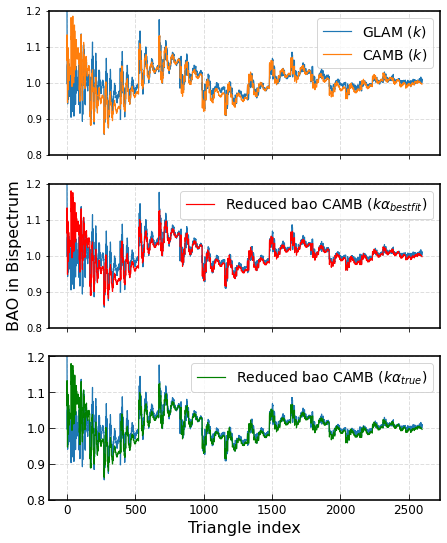

In [62]:
fig, ax = plt.subplots(3,sharex=True, sharey=True,figsize = (7,9))
for axis in ['top','bottom','left','right']:
    ax[0].spines[axis].set_linewidth(1.6)
    ax[1].spines[axis].set_linewidth(1.6)
    ax[2].spines[axis].set_linewidth(1.6)

ax[0].plot(bglamwt,linewidth = 1.2,label = r"GLAM $(k)$")
ax[0].plot(bcambrw,linewidth = 1.2,label = r"CAMB $(k)$")
ax[0].set_ylim(0.8,1.2)

ax[1].plot(bglamwt,linewidth = 1.2,)
ax[1].plot(bcambrwa, "r-", linewidth = 1.2, label =  r"Reduced bao CAMB $(k\alpha_{bestfit})$")
ax[1].set_ylabel("BAO in Bispectrum", fontsize = 16)

ax[2].plot(bglamwt,linewidth = 1.2,)
ax[2].plot(bcambrwat, "g-",linewidth = 1.2, label =  r"Reduced bao CAMB $(k\alpha_{true})$")
ax[2].set_xlabel("Triangle index", fontsize = 16)

ax[0].grid(True, alpha=0.4, linewidth=1, linestyle='--')
ax[1].grid(True, alpha=0.4, linewidth=1, linestyle='--')
ax[2].set_ylim([0.8, 1.2])
ax[2].set_yticks(np.linspace(0.8, 1.2, 5))
ax[2].tick_params(direction='in', size=6, labelsize=12)
ax[2].grid(True, alpha=0.4, linewidth=1, linestyle='--')

ax[0].legend(fontsize = 14)
ax[1].legend(fontsize = 14)
ax[2].legend(fontsize = 14)
# plt.savefig("plots/bi_bao_mod.png", dpi = 300)


2600
30
435


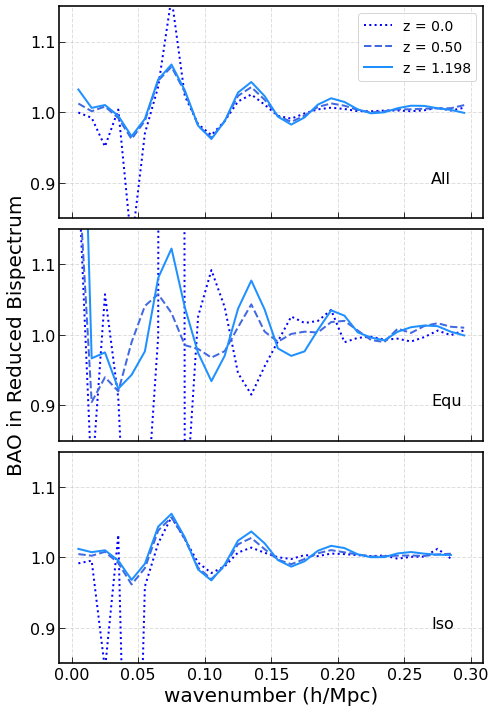

In [107]:
import matplotlib.cm as cm
colors = ["blue","royalblue","dodgerblue"]
linestyles= ['-',"--",":"]
linestyles.reverse()
fig,ax= plt.subplots(3,sharex=True, sharey = True, figsize = (7,10))
props = dict(boxstyle='square', facecolor='wheat', alpha=0.5)
kconfig = {"All" : all_index, "Equ" : equi_index, "Iso" : iso_index}

k = 0
for conf, ind in kconfig.items():
    print(len(ind[0]))
    for axis in ['top','bottom','left','right']:
        ax[k].spines[axis].set_linewidth(1.6)
    
    for i in range(0,len(zs),2):
        index = int(i/2)
        wiggles = all_means_bk[zs[i]]["BAO"]/all_means_bk[zs[i]]["noBAO"]
        ax[k].plot(*marginalize(kk[ind][:,0],wiggles[ind]),color = colors[index],linewidth = 2, linestyle = linestyles[index],label =str(zs[i][0])+ " = "+ str(zs[i][1:]))
    ax[k].text(0.27 , 0.9, conf, fontsize = 16)
    ax[k].set_ylim(0.85,1.15)
    ax[k].set_yticks(np.arange(0.9, 1.1, 0.1))
    ax[k].tick_params(direction='in', size=6, labelsize=16)
    ax[k].grid(True, alpha=0.4, linewidth=1, linestyle='--')
    k = k+1

ax[0].legend(loc = "upper right", fontsize = 14)
ax[1].set_ylabel("BAO in Reduced Bispectrum", fontsize = 20)
ax[2].set_xlabel(r"wavenumber (h/Mpc)",fontsize = 20)
plt.tight_layout()
plt.savefig("plots_new/bks_zs_mod.png", dpi = 300)

all_mcmc_results/glam_parallel_kmin0/mcmc_glam_z0.0_01_p6.h5
(840, 6) bk_z0.0_01.npz
[ 0.99916388  0.13011737  2.03503682 -0.73505137 14.84281261 -4.9320937 ] [0.9991638773927486, 0.13011737001425813, 2.03503682443945, -0.7350513674081974, 6, 14.842812610199662, -4.932093702754133]
0.6777
all_mcmc_results/glam_parallel_kmin0/mcmc_glam_z0.50_03_p6.h5
(840, 6) bk_z0.50_03.npz
[ 0.99906355  0.08255857  1.80459086 -0.0811995   8.43275489 -4.22914596] [0.9990635450967462, 0.08255856838505052, 1.8045908561316737, -0.08119950010017171, 5.5, 8.432754890991296, -4.229145963462269]
0.6777
all_mcmc_results/glam_parallel_kmin0/mcmc_glam_z1.198_05_p6.h5
(840, 6) bk_z1.198_05.npz
[ 0.99910142  0.04893686  1.6198329   1.17660006 -0.34318748 -3.3963823 ] [0.9991014197210203, 0.04893685816255441, 1.6198329005068526, 1.1766000593202601, 5.0, -0.34318747685835066, -3.3963822963243397]
0.6777


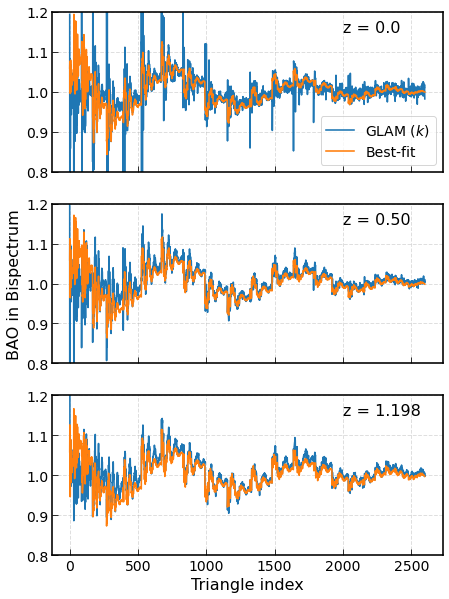

In [108]:
from pathlib import Path
filepaths = "data/glam"

fig, ax = plt.subplots(3,sharex=True, sharey=True,figsize = (7,10))
for axis in ['top','bottom','left','right']:
    ax[0].spines[axis].set_linewidth(1.6)
    ax[1].spines[axis].set_linewidth(1.6)
    ax[2].spines[axis].set_linewidth(1.6)
E = 6
for i in range(0,len(zs),2):
    for file in os.listdir(filepaths):
        if file[-3:] == "npz" and file[:2] == "bk" and "mehdi" not in file and file.endswith(f"{i+1:02}.npz"):
            bpath = os.path.join(filepaths, file)
            ppath = os.path.join(filepaths, "pk"+file[2:])
            Bk=np.load(bpath)
            Pk=np.load(ppath)

            k,pkm,pknm,pk,pkn=Pk['k'], Pk['pkm'],Pk['pknm'],Pk['pk'],Pk['pkn']
            kk,bkm,bknm,bk,bkn=Bk['kk'], Bk['bkm'], Bk['bknm'],Bk['bk'],Bk['bkn']
            
            mcmc_path = "all_mcmc_results/glam_parallel_kmin0/mcmc_glam_" + Path(bpath).stem[3:] + "_p6.h5"
            reader = emcee.backends.HDFBackend(mcmc_path,read_only=True)

            print(mcmc_path)

            flat_samples = reader.get_chain(discard=1000, thin=80, flat=True)
            print(flat_samples.shape, file)
            params = np.mean(flat_samples, axis = 0)
            params_new = [0]* int(len(params)+1) #adds the damping parameter E and sets value to 5
            params_new[:4] = params[:4]
            params_new[4] = E
            params_new[5:] = params[4:]
            print(params, params_new)
            bfull,bsmooth,bwiggle = get_smooth(kg,*params_new) 
             
            k = int(i/2)
            ax[k].plot(bkm/bknm,linewidth = 1.6,label = r"GLAM $(k)$")
            ax[k].plot(bwiggle,linewidth = 1.6,label = r"Best-fit")
            ax[k].grid(True, alpha=0.4, linewidth=1, linestyle='--')
            ax[k].text(2000, 1.15,str(zs[i][0])+ " = "+ str(zs[i][1:]), fontsize = 16)

            ax[k].set_ylim(0.8,1.2)
    E-=0.5
ax[1].set_ylabel("BAO in Bispectrum", fontsize = 16)
ax[2].set_xlabel("Triangle index", fontsize = 16)
ax[2].set_ylim([0.8, 1.2])
ax[2].set_yticks(np.linspace(0.8, 1.2, 5))
ax[0].tick_params(direction='in', size=6, labelsize=14)
ax[1].tick_params(direction='in', size=6, labelsize=14)
ax[2].tick_params(direction='in', size=6, labelsize=14)
ax[0].legend(loc = "lower right",fontsize = 14)

plt.savefig("plots_new/glam_bk_zs.png", dpi = 300)


In [ ]:
import numpy as np
import argparse
import pathlib
import os, sys
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
from pathlib import Path
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
sys.path.append("/global/homes/s/shreeb/BAO_bispectrum/nobao_project/slurm")
from my_utils.mcmc.mcmc import RunMCMC
from my_utils.utils import *

import math
import warnings          # for ignoring the warnings (not recommended)
warnings.filterwarnings('ignore')

Bk_molino=np.load("../Molino_mocks/bk_molino_z0.npz")
bk_mol = Bk_molino["bk0"]

def prepare_pk(k,E = None, use_glam = True):
    if use_glam:
        pkmf = pkm
        pknmf = pknm     
    else:
        pkcamb = np.loadtxt(filepath)
        # pkcamb[:,1] = pkcamb[:,1]/np.max(pkcamb[:,1]) * np.max(pkm)
        _,pknmf,pkmf = less_baoPk(pkcamb,k,h,E)
    # plt.plot(pkmf/pknmf)
    return pkmf,pknmf

def model_fullBk(kk,*args):
    alpha,f,b1,b2,E,S0,S1= args
    
    pkmf,pknmf = prepare_pk(k,E,use_glam = False)

    pk1=np.interp(alpha*kk[:,0],k,pkmf)
    pk2=np.interp(alpha*kk[:,1],k,pkmf)
    pk3=np.interp(alpha*kk[:,2],k,pkmf)
    
    pkn1=np.interp(alpha*kk[:,0],k,pknm)
    pkn2=np.interp(alpha*kk[:,1],k,pknm)
    pkn3=np.interp(alpha*kk[:,2],k,pknm)
    
    res = Bi0(alpha*kk,pk1,pk2,pk3,f,b1,b2,S0,S1) #Bi_wiggle(alpha*kk,pk1,pk2,pk3,pkn1,pkn2,pkn3,f,b1,b2,S0,S1) #
    return res

def curvefit_fullBk(kk,bkm):
    k1,k2,k3=kk[:,0],kk[:,1],kk[:,2]
    r=np.array(k1*k2*k3)**2
    model = lambda kk,alpha,f,b1,b2,E,S0,S1 : model_fullBk(kk,alpha,f,b1,b2,E,S0,S1)
    b0 = [  1,   0.09231214,   1.77502499,  -0.93034206, 4.19969726, 0 ,  10]
    bopt, bcov = curve_fit(model_fullBk,kk,bkm,b0,1/r,maxfev=10000)
    print(bopt)
    pkmf,pknmf = prepare_pk(k,bopt[-3],use_glam = False)
    # plt.plot(pkmf/pknmf)
    return bopt

def model(kk,*args):
    # alpha,f,b1,b2,E,S0,S1 = args
    alpha,E = args

    pkm,pknm = prepare_pk(k,E,use_glam = False)

    pk1=np.interp(alpha*kk[:,0],k,pkm)
    pk2=np.interp(alpha*kk[:,1],k,pkm)
    pk3=np.interp(alpha*kk[:,2],k,pkm)

    pkn1=np.interp(alpha*kk[:,0],k,pknm)
    pkn2=np.interp(alpha*kk[:,1],k,pknm)
    pkn3=np.interp(alpha*kk[:,2],k,pknm)

    res = Bi_wiggle(alpha*kk,pk1,pk2,pk3,pkn1,pkn2,pkn3,f,b1,b2,S0,S1)      #*Bi0(kk,pkn11,pkn12,pkn13,f,b1,b2,S0,S1)
    return res


kmax=0.2, kmin=0, nbins=825, nmocks=922, hf = 9.694736842105263
1 /pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/data/camb_new/camb_python/camb_67772890_matterpower_z0.5_0057.dat
[ 9.84495846e-01 -2.11939853e-03  1.63631847e-02 -7.98324849e-03
  4.42690694e+00 -1.69136912e+01  1.80319845e-02]
[ 9.84495846e-01 -2.11939853e-03  1.63631847e-02 -7.98324849e-03
  4.42690694e+00 -1.69136912e+01  1.80319845e-02]


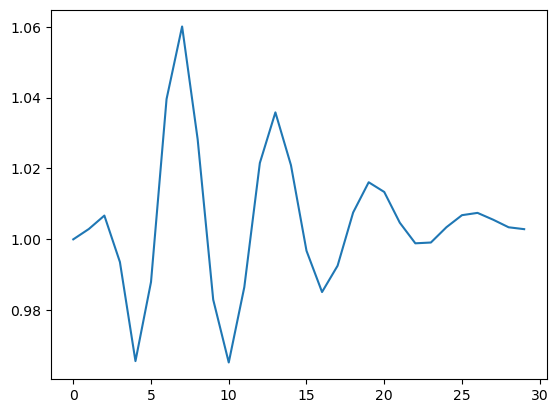

In [433]:
filepaths = "/pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/data/camb_new/camb_python"

# CAMB filepaths for single z and different pk
Bk=np.load("data/withbao_glam/bk_z0.50_03.npz")
Pk=np.load("data/withbao_glam/pk_z0.50_03.npz")
k,pkm,pknm,pk,pkn=Pk['k'], Pk['pkm'],Pk['pknm'],Pk['pk'],Pk['pkn']
kk,bkm,bknm,bk,bkn,bao=Bk['kk'], Bk['bkm'], Bk['bknm'],Bk['bk'],Bk['bkn'],Bk['bk_bao']

index = 57
plt.plot(pkm/pknm)
kg,bg,bgn,cov,scaled_cov,_, bao_cov = cutslice(0,0.2,kk,bkm,bk,bknm,bkn,bk_mol,bao)
icov = np.linalg.inv(bao_cov)
fullbk_bestfits = []
for file in os.listdir(filepaths):
    if file[-3:] == "dat" and file.endswith(f"{index:04}.dat"):
        filepath = os.path.join(filepaths, file)
        # h = int(pathlib.PurePath(filepath).name[5:9])/10000
        # k = k*h
        # kk = kk*h
        # kg = kg*h
        h = 1
        print(h,filepath)
        bopt = curvefit_fullBk(kg,bg)
        print(bopt)
        # fullbk_bestfits.append(bopt)

In [435]:
bopt

array([ 9.84495846e-01, -2.11939853e-03,  1.63631847e-02, -7.98324849e-03,
        4.42690694e+00, -1.69136912e+01,  1.80319845e-02])

In [26]:
np.load("/pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/data/camb_new/camb_python_info/infocamb_65772890_matterpower_z0.5_0013.npy", allow_pickle = True)

array({'age': 14.456621560992014, 'zstar': 1090.4172854127935, 'rstar': 149.95922811824502, 'thetastar': 1.0219427337850113, 'DAstar': 14.673936528990708, 'zdrag': 1055.1567399658518, 'rdrag': 153.29658070195762, 'kd': 0.1334078584070684, 'thetad': 0.16048033562573136, 'zeq': 2987.2929308599796, 'keq': 0.009117962558860231, 'thetaeq': 0.8756581714337838, 'thetarseq': 0.48262187506845156},
      dtype=object)

In [224]:
np.load("/pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/data/camb_new/camb_python_info/infocamb_67773070_matterpower_z0.5_0060.npy", allow_pickle = True)

array({'age': 13.797886946092621, 'zstar': 1090.0808002186989, 'rstar': 144.89553496543132, 'thetastar': 1.0416770140835014, 'DAstar': 13.909833183073042, 'zdrag': 1059.3647472364162, 'rdrag': 147.6365451933761, 'kd': 0.1401317850733938, 'thetad': 0.16117263147874375, 'zeq': 3369.411963896559, 'keq': 0.010283818266334331, 'thetaeq': 0.8190315978839322, 'thetarseq': 0.45256329676905177},
      dtype=object)

In [34]:
(147.64/153.296)*(67.77/65.77)

0.9923910925081897

In [229]:
np.load("/pscratch/sd/s/shreeb/shreeb/BAO_Bispectrum_with_data/nobao_project/data/camb_new/camb_python_info/infocamb_70273369_matterpower_z0.5_0120.npy", allow_pickle = True)

array({'age': 12.963893552118956, 'zstar': 1089.985506269203, 'rstar': 137.97016328743476, 'thetastar': 1.0669232054373758, 'DAstar': 12.931592694234736, 'zdrag': 1064.7348939477804, 'rdrag': 140.04661838879844, 'kd': 0.14978404099727866, 'thetad': 0.16219307675799705, 'zeq': 3976.767993170938, 'keq': 0.012136892306894749, 'thetaeq': 0.7464750591998853, 'thetarseq': 0.41399024906428245},
      dtype=object)

In [230]:
147.64/140.05, 1.018

1.0541949303820062

In [8]:
(147.64/140.05)*(67.77/70.27), 1.016

(1.0166897741851226, 1.016)

1/1.01668

## ICs Pk

In [3]:
from urllib.request import urlretrieve

In [6]:
pk_full = urlretrieve("http://skun.iaa.es/SUsimulations/GLAM/1GpcPmill/","PkTable.dat")
pk_smooth = urlretrieve("http://skun.iaa.es/SUsimulations/GLAM/1GpcPmillNowig/","PkTable.dat")

In [9]:
path, headers = urlretrieve("http://skun.iaa.es/SUsimulations/GLAM/1GpcPmill/","PkTable.dat")

for name, value in headers.items():
    print(name, value)

Date Mon, 04 Dec 2023 22:20:18 GMT
Server Apache
Content-Length 2638
Connection close
Content-Type text/html;charset=UTF-8


In [3]:
pk_full = np.loadtxt("pk_full.dat")
pk_smooth = np.loadtxt("pk_smooth.dat")

kf = pk_full[:,0]
ks = pk_smooth[:,0]

pf = pk_full[:,1]
ps = pk_smooth[:,1]

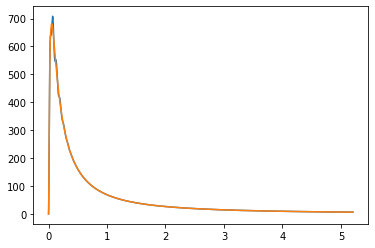

In [24]:
plt.plot(kf,pf*kf)
plt.plot(kf,ps*kf)

(-0.01, 0.5)

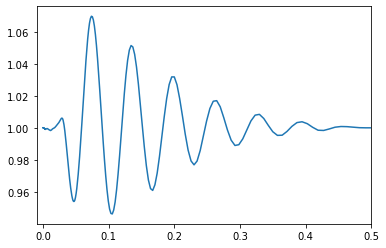

In [29]:
plt.plot(kf,pf/ps)
plt.xlim(-0.01,0.5)

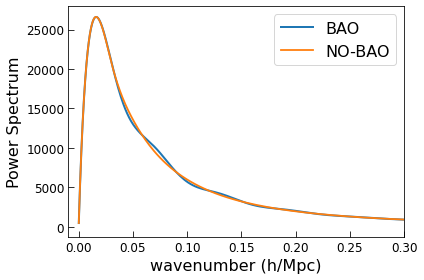

In [83]:
# plt.figure(figsize = (7,5))
plt.plot(kf,pf, linewidth = 2, label = "BAO")
plt.plot(kf,ps, linewidth = 1.8,label = "NO-BAO")
plt.xlabel('wavenumber (h/Mpc)', fontsize=16)
plt.ylabel('Power Spectrum', fontsize=16)
plt.xlim([-0.01, 0.3])
plt.xticks([0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30])
# plt.xlim([0, 0.5])
# plt.xticks([0.0, 0.10, 0.20, 0.30, 0.4, 0.5])

# plt.ylim([0.92, 1.08])
# plt.yticks(np.arange(0.94, 1.06, step=0.02))
plt.tick_params(direction='in', size=6, labelsize=12)
plt.legend(fontsize=16)
# plt.grid(True, alpha=0.4, linewidth=1, linestyle='--')
plt.tight_layout()
plt.savefig('plots_new/pks_ic.png', dpi=200)

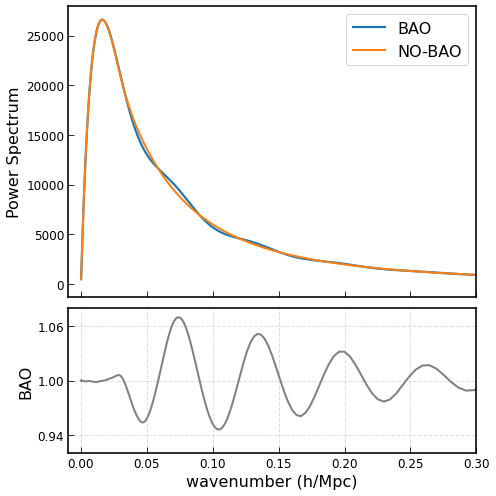

In [54]:
fig, ax = plt.subplots(2,sharex=True, sharey = False, figsize = (7,7),gridspec_kw={'height_ratios': [2,1]})

for axis in ['top','bottom','left','right']:
    ax[0].spines[axis].set_linewidth(1.6)
    ax[1].spines[axis].set_linewidth(1.6)

ax[0].plot(kf,pf, linewidth = 2.2, label = "BAO")
ax[0].plot(kf,ps, linewidth = 2,label = "NO-BAO")

ax[0].set_ylabel('Power Spectrum', fontsize=16)
ax[0].legend(fontsize=16)
ax[0].tick_params(direction='in', size=6, labelsize=12)


ax[1].set_xlim([-0.01, 0.3])
ax[1].set_xticks([0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30])
ax[1].plot(kf,pf/ps, color = "grey", linewidth = 2)
ax[1].set_xlabel('wavenumber (h/Mpc)', fontsize=16)
ax[1].set_ylabel('BAO', fontsize=16)

ax[1].set_ylim([0.92, 1.08])
ax[1].set_yticks(np.arange(0.94, 1.08, step=0.06))
ax[1].tick_params(direction='in', size=6, labelsize=12)
ax[1].grid(True, alpha=0.4, linewidth=1, linestyle='--')
plt.tight_layout()
# ax[1].legend(loc = "upper right", fontsize = 14)

plt.savefig("plots_new/bao_pk_ics.png", dpi = 200)